# Processing Farm 1
0~1000

In [1]:
farm_start_idx = 0
farm_end_idx = 1000

In [2]:
import os
from os.path import join, exists, isfile, realpath, dirname
import argparse
from glob import glob
import random, shutil, json
from math import log10, ceil

import torch.nn as nn
from torch.utils.data import DataLoader, SubsetRandomSampler
import torchvision.models as models
from torch.utils.data.dataset import Subset

import faiss

import netvlad

import torch.optim as optim
from tensorboardX import SummaryWriter

from datetime import datetime
from os import makedirs, remove, chdir, environ

import matplotlib.pyplot as plt

import cv2

import open3d as o3d
import numpy as np
from scipy.spatial.transform import Rotation as R

import pyquaternion as pyq
import math
from tqdm import tqdm

import sys

import time

import utility

import imp

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"
weight_dir = 'Jun10_11-22-16_vgg16_netvlad'
lidar_map_pcd = None

In [4]:
parser = argparse.ArgumentParser(description='pytorch-NetVlad')
parser.add_argument('--mode', type=str, default='train', help='Mode', choices=['train', 'test', 'cluster'])
parser.add_argument('--batchSize', type=int, default=4, help='Number of triplets (query, pos, negs). Each triplet consists of 12 images.')
parser.add_argument('--cacheBatchSize', type=int, default=24, help='Batch size for caching and testing')
parser.add_argument('--cacheRefreshRate', type=int, default=1000, help='How often to refresh cache, in number of queries. 0 for off')
parser.add_argument('--nEpochs', type=int, default=30, help='number of epochs to train for')
parser.add_argument('--start-epoch', default=0, type=int, metavar='N', help='manual epoch number (useful on restarts)')
parser.add_argument('--nGPU', type=int, default=1, help='number of GPU to use.')
parser.add_argument('--optim', type=str, default='SGD', help='optimizer to use', choices=['SGD', 'ADAM'])
parser.add_argument('--lr', type=float, default=0.0001, help='Learning Rate.')
parser.add_argument('--lrStep', type=float, default=5, help='Decay LR ever N steps.')
parser.add_argument('--lrGamma', type=float, default=0.5, help='Multiply LR by Gamma for decaying.')
parser.add_argument('--weightDecay', type=float, default=0.001, help='Weight decay for SGD.')
parser.add_argument('--momentum', type=float, default=0.9, help='Momentum for SGD.')
parser.add_argument('--nocuda', action='store_true', help='Dont use cuda')
parser.add_argument('--threads', type=int, default=8, help='Number of threads for each data loader to use')
parser.add_argument('--seed', type=int, default=123, help='Random seed to use.')
parser.add_argument('--dataPath', type=str, default='/home/ubuntu/Desktop/pytorch-NetVlad/data/', help='Path for centroid data.')
parser.add_argument('--runsPath', type=str, default='/home/ubuntu/Desktop/pytorch-NetVlad/runs/', help='Path to save runs to.')
parser.add_argument('--savePath', type=str, default='checkpoints', help='Path to save checkpoints to in logdir. Default=checkpoints/')
parser.add_argument('--cachePath', type=str, default='/tmp', help='Path to save cache to.')
parser.add_argument('--resume', type=str, default='', help='Path to load checkpoint from, for resuming training or testing.')
parser.add_argument('--ckpt', type=str, default='latest', help='Resume from latest or best checkpoint.', choices=['latest', 'best'])
parser.add_argument('--evalEvery', type=int, default=1, help='Do a validation set run, and save, every N epochs.')
parser.add_argument('--patience', type=int, default=10, help='Patience for early stopping. 0 is off.')
parser.add_argument('--dataset', type=str, default='pittsburgh', help='Dataset to use', choices=['pittsburgh','naverlabs'])
parser.add_argument('--arch', type=str, default='vgg16', help='basenetwork to use', choices=['vgg16', 'alexnet'])
parser.add_argument('--vladv2', action='store_true', help='Use VLAD v2')
parser.add_argument('--pooling', type=str, default='netvlad', help='type of pooling to use', choices=['netvlad', 'max', 'avg'])
parser.add_argument('--num_clusters', type=int, default=64, help='Number of NetVlad clusters. Default=64')
parser.add_argument('--margin', type=float, default=0.1, help='Margin for triplet loss. Default=0.1')
parser.add_argument('--split', type=str, default='val', help='Data split to use for testing. Default is val', choices=['test', 'test250k', 'train', 'val'])
parser.add_argument('--fromscratch', action='store_true', help='Train from scratch rather than using pretrained models')

_StoreTrueAction(option_strings=['--fromscratch'], dest='fromscratch', nargs=0, const=True, default=False, type=None, choices=None, help='Train from scratch rather than using pretrained models', metavar=None)

In [5]:
import torch
import torchvision.transforms as transforms
import torch.utils.data as data

from os.path import join, exists
from scipy.io import loadmat
import numpy as np
from collections import namedtuple
from PIL import Image

from sklearn.neighbors import NearestNeighbors
import h5py

def input_transform():
    return transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                              std=[0.229, 0.224, 0.225]),
    ])

def get_whole_test_set():
    return WholeDatasetFromStruct(input_transform=input_transform(), mode='test')

dbStruct = namedtuple('dbStruct', ['whichSet', 'dataset', 
                                   'db_image', 'db_utms', 'db_num', 'db_full_pose',
                                   'q_image', 'q_utms', 'q_num', 'q_full_pose',
                                   'posDistThr', 'posDistSqThr', 'nonTrivPosDistSqThr'])

class WholeDatasetFromStruct(data.Dataset):
    def __init__(self, input_transform=None, mode='train'):
        super().__init__()

        self.input_transform = input_transform

        self.dbStruct = my_parse_dbStruct(mode)
        self.images = np.hstack([self.dbStruct.db_image, self.dbStruct.q_image])

        self.whichSet = self.dbStruct.whichSet
        self.dataset = self.dbStruct.dataset

        self.positives = None
        self.distances = None

    def __getitem__(self, index):
        img = Image.open(self.images[index])
        img = img.resize((640, 480))

        if self.input_transform:
            img = self.input_transform(img)

        return img, index

    def __len__(self):
        return len(self.images)

    def getPositives(self):
        # positives for evaluation are those within trivial threshold range
        #fit NN to find them, search by radius
        if  self.positives is None:
            knn = NearestNeighbors(n_jobs=-1)
            knn.fit(self.dbStruct.db_utms)

            self.distances, self.positives = knn.radius_neighbors(self.dbStruct.q_utms, radius=self.dbStruct.posDistThr)

        return self.positives


In [6]:
def my_parse_dbStruct(_whichSet='train'):

    whichSet = _whichSet
    dataset = 'naverlabs'
    
    # for (2019-04-16_15-35-46)
    image_path = '/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/b1/train/2019-04-16_15-35-46/images'
    image_files_list = []
    image_files_list.append(sorted(glob(os.path.join(image_path, '22970285*.jpg'))))
    image_files_list.append(sorted(glob(os.path.join(image_path, '22970286*.jpg'))))
    image_files_list.append(sorted(glob(os.path.join(image_path, '22970288*.jpg'))))
    image_files_list.append(sorted(glob(os.path.join(image_path, '22970289*.jpg'))))
    image_files_list.append(sorted(glob(os.path.join(image_path, '22970290*.jpg'))))
    image_files_list.append(sorted(glob(os.path.join(image_path, '22970291*.jpg'))))
    
    gt_path = '/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/b1/train/2019-04-16_15-35-46/groundtruth.hdf5'
    full_pose_list = []
    with h5py.File(gt_path, "r") as f:
        full_pose_list.append(np.array(f['22970285_pose']))
        full_pose_list.append(np.array(f['22970286_pose']))
        full_pose_list.append(np.array(f['22970288_pose']))
        full_pose_list.append(np.array(f['22970289_pose']))
        full_pose_list.append(np.array(f['22970290_pose']))
        full_pose_list.append(np.array(f['22970291_pose']))
    
    # for (2019-04-16_16-14-48)
    image_path = '/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/b1/train/2019-04-16_16-14-48/images'
    image_files_list.append(sorted(glob(os.path.join(image_path, '22970285*.jpg'))))
    image_files_list.append(sorted(glob(os.path.join(image_path, '22970286*.jpg'))))
    image_files_list.append(sorted(glob(os.path.join(image_path, '22970288*.jpg'))))
    image_files_list.append(sorted(glob(os.path.join(image_path, '22970289*.jpg'))))
    image_files_list.append(sorted(glob(os.path.join(image_path, '22970290*.jpg'))))
    image_files_list.append(sorted(glob(os.path.join(image_path, '22970291*.jpg'))))
    image_files_list.append(sorted(glob(os.path.join(image_path, 'AC01324954*.jpg'))))
    image_files_list.append(sorted(glob(os.path.join(image_path, 'AC01324955*.jpg'))))
    image_files_list.append(sorted(glob(os.path.join(image_path, 'AC01324969*.jpg'))))
    
    gt_path = '/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/b1/train/2019-04-16_16-14-48/groundtruth.hdf5'
    with h5py.File(gt_path, "r") as f:
        full_pose_list.append(np.array(f['22970285_pose']))
        full_pose_list.append(np.array(f['22970286_pose']))
        full_pose_list.append(np.array(f['22970288_pose']))
        full_pose_list.append(np.array(f['22970289_pose']))
        full_pose_list.append(np.array(f['22970290_pose']))
        full_pose_list.append(np.array(f['22970291_pose']))
        full_pose_list.append(np.array(f['AC01324954_pose']))
        full_pose_list.append(np.array(f['AC01324955_pose']))
        full_pose_list.append(np.array(f['AC01324969_pose']))
    
    # for (2019-08-20_10-41-18)
    image_path = '/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/b1/train/2019-08-20_10-41-18/images'
    image_files_list.append(sorted(glob(os.path.join(image_path, 'AC01324954*.jpg'))))
    image_files_list.append(sorted(glob(os.path.join(image_path, 'AC01324955*.jpg'))))
    image_files_list.append(sorted(glob(os.path.join(image_path, 'AC01324968*.jpg'))))
    image_files_list.append(sorted(glob(os.path.join(image_path, 'AC01324969*.jpg'))))
    
    gt_path = '/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/b1/train/2019-08-20_10-41-18/groundtruth.hdf5'
    with h5py.File(gt_path, "r") as f:
        full_pose_list.append(np.array(f['AC01324954_pose']))
        full_pose_list.append(np.array(f['AC01324955_pose']))
        full_pose_list.append(np.array(f['AC01324968_pose']))
        full_pose_list.append(np.array(f['AC01324969_pose']))
       
    db_image = np.hstack(image_files_list)
    db_full_pose = np.vstack(full_pose_list)
    db_num = len(db_image)
    db_utms = db_full_pose[:,:2]
    
    image_path = '/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/b1/test/2019-08-21_09-49-05/images'
    image_files_list = []
    image_files_list.append(sorted(glob(os.path.join(image_path, '40027089*.jpg'))))
    image_files_list.append(sorted(glob(os.path.join(image_path, '40029628*.jpg'))))
    image_files_list.append(sorted(glob(os.path.join(image_path, '40030065*.jpg'))))
    image_files_list.append(sorted(glob(os.path.join(image_path, '40031951*.jpg'))))
    image_files_list.append(sorted(glob(os.path.join(image_path, '40033113*.jpg'))))
    image_files_list.append(sorted(glob(os.path.join(image_path, '40033116*.jpg'))))
    image_files_list.append(sorted(glob(os.path.join(image_path, 'AC01324954*.jpg'))))
    image_files_list.append(sorted(glob(os.path.join(image_path, 'AC01324955*.jpg'))))
    image_files_list.append(sorted(glob(os.path.join(image_path, 'AC01324968*.jpg'))))
    image_files_list.append(sorted(glob(os.path.join(image_path, 'AC01324969*.jpg'))))
    image_files = np.hstack(image_files_list)
    
    ####### for processing farm
    image_files = image_files[farm_start_idx:farm_end_idx]
    
    q_image = image_files
    q_utms = None
    q_num = len(q_image)
    q_full_pose = None    

    return dbStruct(whichSet, dataset, 
                    db_image, db_utms, db_num, db_full_pose,
                    q_image, q_utms, q_num, q_full_pose, 
                    5, 25, 20.0)

In [7]:
opt = parser.parse_args(args=('--dataset=naverlabs --mode=test --resume=runs/%s --split=test' % weight_dir).split(' '))
restore_var = ['lr', 'lrStep', 'lrGamma', 'weightDecay', 'momentum', 
            'runsPath', 'savePath', 'arch', 'num_clusters', 'pooling', 'optim',
            'margin', 'seed', 'patience']

flag_file = join(opt.resume, 'checkpoints', 'flags.json')
if exists(flag_file):
    with open(flag_file, 'r') as f:
        stored_flags = {'--'+k : str(v) for k,v in json.load(f).items() if k in restore_var}
        to_del = []
        for flag, val in stored_flags.items():
            for act in parser._actions:
                if act.dest == flag[2:]:
                    # store_true / store_false args don't accept arguments, filter these 
                    if type(act.const) == type(True):
                        if val == str(act.default):
                            to_del.append(flag)
                        else:
                            stored_flags[flag] = ''
        for flag in to_del: del stored_flags[flag]

        train_flags = [x for x in list(sum(stored_flags.items(), tuple())) if len(x) > 0]
        print('Restored flags:', train_flags)
        opt = parser.parse_args(train_flags, namespace=opt)




Restored flags: ['--optim', 'SGD', '--lr', '0.0001', '--lrStep', '5', '--lrGamma', '0.5', '--weightDecay', '0.001', '--momentum', '0.9', '--seed', '123', '--runsPath', '/home/ubuntu/Desktop/pytorch-NetVlad/runs/', '--savePath', '/home/ubuntu/Desktop/pytorch-NetVlad/runs/Jun10_11-22-16_vgg16_netvlad/checkpoints', '--patience', '10', '--arch', 'vgg16', '--pooling', 'netvlad', '--num_clusters', '64', '--margin', '0.1']


In [8]:
print(opt)

Namespace(arch='vgg16', batchSize=4, cacheBatchSize=24, cachePath='/tmp', cacheRefreshRate=1000, ckpt='latest', dataPath='/home/ubuntu/Desktop/pytorch-NetVlad/data/', dataset='naverlabs', evalEvery=1, fromscratch=False, lr=0.0001, lrGamma=0.5, lrStep=5.0, margin=0.1, mode='test', momentum=0.9, nEpochs=30, nGPU=1, nocuda=False, num_clusters=64, optim='SGD', patience=10, pooling='netvlad', resume='runs/Jun10_11-22-16_vgg16_netvlad', runsPath='/home/ubuntu/Desktop/pytorch-NetVlad/runs/', savePath='/home/ubuntu/Desktop/pytorch-NetVlad/runs/Jun10_11-22-16_vgg16_netvlad/checkpoints', seed=123, split='test', start_epoch=0, threads=8, vladv2=False, weightDecay=0.001)


In [9]:
cuda = True
device = torch.device("cuda")
random.seed(opt.seed)
np.random.seed(opt.seed)
torch.manual_seed(opt.seed)
torch.cuda.manual_seed(opt.seed)

In [10]:
whole_test_set = get_whole_test_set()

In [11]:
encoder_dim = 512
encoder = models.vgg16(pretrained=True)
# capture only feature part and remove last relu and maxpool
layers = list(encoder.features.children())[:-2]

# if using pretrained then only train conv5_1, conv5_2, and conv5_3
for l in layers[:-5]: 
    for p in l.parameters():
        p.requires_grad = False

In [12]:
encoder = nn.Sequential(*layers)
model = nn.Module() 
model.add_module('encoder', encoder)

In [13]:
net_vlad = netvlad.NetVLAD(num_clusters=opt.num_clusters, dim=encoder_dim, vladv2=opt.vladv2)
if not opt.resume: 
    if opt.mode.lower() == 'train':
        initcache = join(opt.dataPath, 'centroids', opt.arch + '_' + train_set.dataset + '_' + str(opt.num_clusters) +'_desc_cen.hdf5')
    else:
        initcache = join(opt.dataPath, 'centroids', opt.arch + '_' + whole_test_set.dataset + '_' + str(opt.num_clusters) +'_desc_cen.hdf5')

    if not exists(initcache):
        raise FileNotFoundError('Could not find clusters, please run with --mode=cluster before proceeding')

    with h5py.File(initcache, mode='r') as h5: 
        clsts = h5.get("centroids")[...]
        traindescs = h5.get("descriptors")[...]
        net_vlad.init_params(clsts, traindescs) 
        del clsts, traindescs

model.add_module('pool', net_vlad)

In [14]:
if opt.ckpt.lower() == 'latest':
    resume_ckpt = join(opt.resume, 'checkpoints', 'checkpoint.pth.tar')
elif opt.ckpt.lower() == 'best':
    resume_ckpt = join(opt.resume, 'checkpoints', 'model_best.pth.tar')

if isfile(resume_ckpt):
    print("=> loading checkpoint '{}'".format(resume_ckpt))
    checkpoint = torch.load(resume_ckpt, map_location=lambda storage, loc: storage)
    opt.start_epoch = checkpoint['epoch']
    best_metric = checkpoint['best_score']
    model.load_state_dict(checkpoint['state_dict'])
    model = model.to(device)
    if opt.mode == 'train':
        optimizer.load_state_dict(checkpoint['optimizer'])
    print("=> loaded checkpoint '{}' (epoch {})"
          .format(resume_ckpt, checkpoint['epoch']))
else:
    print("=> no checkpoint found at '{}'".format(resume_ckpt))

=> loading checkpoint 'runs/Jun10_11-22-16_vgg16_netvlad/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'runs/Jun10_11-22-16_vgg16_netvlad/checkpoints/checkpoint.pth.tar' (epoch 30)


# Calculate the prediction

In [15]:
test_set = whole_test_set
test_data_loader = DataLoader(dataset=test_set, num_workers=opt.threads, batch_size=opt.cacheBatchSize, shuffle=True, pin_memory=cuda)

In [16]:
start = time.time() 

model.eval()
with torch.no_grad():
    print('====> Extracting Features')
    pool_size = encoder_dim
    if opt.pooling.lower() == 'netvlad': pool_size *= opt.num_clusters
    dbFeat = np.empty((len(test_set), pool_size))

    for iteration, (input, indices) in enumerate(test_data_loader, 1):
        input = input.to(device)
        image_encoding = model.encoder(input)
        vlad_encoding = model.pool(image_encoding) 

        dbFeat[indices.detach().numpy(), :] = vlad_encoding.detach().cpu().numpy()
        if iteration % 50 == 0 or len(test_data_loader) <= 10:
            print("==> Batch ({}/{})".format(iteration, len(test_data_loader)), flush=True)

        del input, image_encoding, vlad_encoding
del test_data_loader

print("end time :", time.time() - start)

====> Extracting Features
==> Batch (50/1158)
==> Batch (100/1158)
==> Batch (150/1158)
==> Batch (200/1158)
==> Batch (250/1158)
==> Batch (300/1158)
==> Batch (350/1158)
==> Batch (400/1158)
==> Batch (450/1158)
==> Batch (500/1158)
==> Batch (550/1158)
==> Batch (600/1158)
==> Batch (650/1158)
==> Batch (700/1158)
==> Batch (750/1158)
==> Batch (800/1158)
==> Batch (850/1158)
==> Batch (900/1158)
==> Batch (950/1158)
==> Batch (1000/1158)
==> Batch (1050/1158)
==> Batch (1100/1158)
==> Batch (1150/1158)
end time : 393.5535271167755


In [ ]:
start = time.time() 

# extracted for both db and query, now split in own sets
qFeat = dbFeat[test_set.dbStruct.db_num:].astype('float32')
dbFeat = dbFeat[:test_set.dbStruct.db_num].astype('float32')

print('====> Building faiss index')
faiss_index = faiss.IndexFlatL2(pool_size)
faiss_index.add(dbFeat)

print('====> Calculating recall @ N')
n_values = [1,5,10,20]

_, predictions = faiss_index.search(qFeat, max(n_values)) 

print("end time :", time.time() - start)

====> Building faiss index


# SuperPoint & SuperGlue

In [30]:
from super_models.matching import Matching
from super_models.utils import (AverageTimer, VideoStreamer,make_matching_plot_fast, frame2tensor)
import matplotlib.cm as cm

In [31]:
parser = argparse.ArgumentParser(description='SuperGlue demo',formatter_class=argparse.ArgumentDefaultsHelpFormatter)
parser.add_argument(
        '--input', type=str, default='0',
        help='ID of a USB webcam, URL of an IP camera, '
             'or path to an image directory or movie file')
parser.add_argument(
    '--output_dir', type=str, default=None,
    help='Directory where to write output frames (If None, no output)')

parser.add_argument(
    '--image_glob', type=str, nargs='+', default=['*.png', '*.jpg', '*.jpeg'],
    help='Glob if a directory of images is specified')
parser.add_argument(
    '--skip', type=int, default=1,
    help='Images to skip if input is a movie or directory')
parser.add_argument(
    '--max_length', type=int, default=1000000,
    help='Maximum length if input is a movie or directory')
parser.add_argument(
    '--resize', type=int, nargs='+', default=[640, 480],
    help='Resize the input image before running inference. If two numbers, '
         'resize to the exact dimensions, if one number, resize the max '
         'dimension, if -1, do not resize')

parser.add_argument(
    '--superglue', choices={'indoor', 'outdoor'}, default='indoor',
    help='SuperGlue weights')
parser.add_argument(
    '--max_keypoints', type=int, default=-1,
    help='Maximum number of keypoints detected by Superpoint'
         ' (\'-1\' keeps all keypoints)')
parser.add_argument(
    '--keypoint_threshold', type=float, default=0.005,
    help='SuperPoint keypoint detector confidence threshold')
parser.add_argument(
    '--nms_radius', type=int, default=4,
    help='SuperPoint Non Maximum Suppression (NMS) radius'
    ' (Must be positive)')
parser.add_argument(
    '--sinkhorn_iterations', type=int, default=20,
    help='Number of Sinkhorn iterations performed by SuperGlue')
parser.add_argument(
    '--match_threshold', type=float, default=0.2,
    help='SuperGlue match threshold')

parser.add_argument(
    '--show_keypoints', action='store_true',
    help='Show the detected keypoints')
parser.add_argument(
    '--no_display', action='store_true',
    help='Do not display images to screen. Useful if running remotely')
parser.add_argument(
    '--force_cpu', action='store_true',
    help='Force pytorch to run in CPU mode.')

opt = parser.parse_args('--resize -1 --max_keypoints 3000'.split(' '))
# opt = parser.parse_args('')
print(opt)

Namespace(force_cpu=False, image_glob=['*.png', '*.jpg', '*.jpeg'], input='0', keypoint_threshold=0.005, match_threshold=0.2, max_keypoints=3000, max_length=1000000, nms_radius=4, no_display=False, output_dir=None, resize=[-1], show_keypoints=False, sinkhorn_iterations=20, skip=1, superglue='indoor')


In [32]:
device = 'cuda'
print('Running inference on device \"{}\"'.format(device))

config = {
    'superpoint': {
        'nms_radius': opt.nms_radius,
        'keypoint_threshold': opt.keypoint_threshold,
        'max_keypoints': opt.max_keypoints
    },
    'superglue': {
        'weights': opt.superglue,
        'sinkhorn_iterations': opt.sinkhorn_iterations,
        'match_threshold': opt.match_threshold,
    }
}
print(config)

Running inference on device "cuda"
{'superpoint': {'nms_radius': 4, 'keypoint_threshold': 0.005, 'max_keypoints': 3000}, 'superglue': {'weights': 'indoor', 'sinkhorn_iterations': 20, 'match_threshold': 0.2}}


In [33]:
def process_resize(w, h, resize):
    assert(len(resize) > 0 and len(resize) <= 2)
    if len(resize) == 1 and resize[0] > -1:
        scale = resize[0] / max(h, w)
        w_new, h_new = int(round(w*scale)), int(round(h*scale))
    elif len(resize) == 1 and resize[0] == -1:
        w_new, h_new = w, h
    else:  # len(resize) == 2:
        w_new, h_new = resize[0], resize[1]

    # Issue warning if resolution is too small or too large.
    if max(w_new, h_new) < 160:
        print('Warning: input resolution is very small, results may vary')
    elif max(w_new, h_new) > 2000:
        print('Warning: input resolution is very large, results may vary')

    return w_new, h_new

def load_image(impath, resize):
    """ Read image as grayscale and resize to img_size.
    Inputs
        impath: Path to input image.
    Returns
        grayim: uint8 numpy array sized H x W.
    """

    camera_model = impath.split('/')[-1].split('_')[0]
    _, A, dist_coeff = utility.intrinsic_params(camera_model)
    
    grayim = cv2.imread(impath, 0)
    grayim = cv2.undistort(grayim, A, dist_coeff)
    if grayim is None:
        raise Exception('Error reading image %s' % impath)
    w, h = grayim.shape[1], grayim.shape[0]
    w_new, h_new = process_resize(w, h, resize)
    grayim = cv2.resize(grayim, (w_new, h_new), interpolation=cv2.INTER_AREA)
    return grayim

In [34]:
def super_matching(matching, query_path, pred_path):
    
    keys = ['keypoints', 'scores', 'descriptors']

    frame = load_image(query_path, opt.resize)
    frame_tensor = frame2tensor(frame, device)
    last_data = matching.superpoint({'image': frame_tensor})
    last_data = {k+'0': last_data[k] for k in keys}
    last_data['image0'] = frame_tensor
    last_frame = frame
    last_image_id = 0

    frame = load_image(pred_path, opt.resize)
    frame_tensor = frame2tensor(frame, device)
    pred = matching({**last_data, 'image1': frame_tensor})
    kpts0 = last_data['keypoints0'][0].cpu().numpy()
    kpts1 = pred['keypoints1'][0].cpu().numpy()
    matches = pred['matches0'][0].cpu().numpy()
    confidence = pred['matching_scores0'][0].cpu().detach().numpy()

    valid = matches > -1
    mkpts0 = kpts0[valid]
    mkpts1 = kpts1[matches[valid]]
    color = cm.jet(confidence[valid])
    text = [
        'SuperGlue',
        'Keypoints: {}:{}'.format(len(kpts0), len(kpts1)),
        'Matches: {}'.format(len(mkpts0))
    ]
    k_thresh = matching.superpoint.config['keypoint_threshold']
    m_thresh = matching.superglue.config['match_threshold']
    
    small_text = [
        'Keypoint Threshold: {:.4f}'.format(k_thresh),
        'Match Threshold: {:.2f}'.format(m_thresh),
    ]
    matching_img = make_matching_plot_fast(
        last_frame, frame, kpts0, kpts1, mkpts0, mkpts1, color, text,
        path=None, show_keypoints=False, small_text=small_text)

    return matching_img, mkpts0, mkpts1

# Load HD Map

In [ ]:
# start = time.time() 

# # VERY TIME CONSUMING!
# lidar_map_pcd1 = o3d.io.read_point_cloud("/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/b1/train/2019-08-20_10-41-18/map.pcd")
# pcd_tree1 = o3d.geometry.KDTreeFlann(lidar_map_pcd1)

# lidar_map_pcd2 = o3d.io.read_point_cloud("/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/b1/train/2019-04-16_16-14-48/map.pcd")
# pcd_tree2 = o3d.geometry.KDTreeFlann(lidar_map_pcd2)

# lidar_map_pcd3 = o3d.io.read_point_cloud("/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/b1/train/2019-04-16_15-35-46/map.pcd")
# pcd_tree3 = o3d.geometry.KDTreeFlann(lidar_map_pcd3)

# print("end time :", time.time() - start)

# All-in-one

In [78]:
import shutil

imp.reload(utility)

def VisualLocalization(dataset, query_idx, debug):
    query_item, pred_list = utility.placeRecognitionTopFive(dataset, predictions, query_idx)
    [query_image_full_path, query_img, _] = query_item
    query_camera_model = query_image_full_path.split('/')[-1].split('_')[0]
    _, query_A, query_dist_coeff = utility.intrinsic_params(query_camera_model)
    
    if (debug): shutil.copy(query_image_full_path, 'debug/%d_query.jpg' % query_idx)

    neighbor_radius = 20.0    

    best_inlier = 0
    best_pose = []
    for rank, pred_item in enumerate(pred_list):
        [pred_image_full_path, pred_img, pred_pose] = pred_item
        if (debug): shutil.copy(pred_image_full_path, 'debug/%d_%d_pred.jpg' % (query_idx, rank))

        acquisition_date = pred_image_full_path.split('/')[-3] 
        if acquisition_date == '2019-08-20_10-41-18':
            pcd = lidar_map_pcd1
            pcd_tree = pcd_tree1
        elif acquisition_date == '2019-04-16_16-14-48':
            pcd = lidar_map_pcd2
            pcd_tree = pcd_tree2
        elif acquisition_date == '2019-04-16_15-35-46':
            pcd = lidar_map_pcd3
            pcd_tree = pcd_tree3

        [k, idx, _] = pcd_tree.search_radius_vector_3d(pred_pose[:3], neighbor_radius) # time consuming
        radius_points = np.asarray(pcd.points)[idx] 

        pred_Rt = np.eye(4)
        pred_Rt[:3,3] = pred_pose[:3]
        (pred_qw, pred_qx, pred_qy, pred_qz) = pred_pose[3:]
        pred_Rt[:3,:3] = R.from_quat([pred_qx,pred_qy,pred_qz,pred_qw]).as_matrix()
        pred_camera_model = pred_image_full_path.split('/')[-1].split('_')[0]
        _, pred_A, pred_dist_coeff = utility.intrinsic_params(pred_camera_model)
        pred_projected_img = utility.projection(pred_img, radius_points, pred_A, pred_Rt, thickness=10) # time consuming 
        if (debug): plt.imsave('debug/%d_%d_pred_projected_img.png' % (query_idx, rank), pred_projected_img[:,:,2])

        # super matching
        matching = Matching(config).eval().to(device)
        matching_img, px_query, px_pred = super_matching(matching, query_item[0], pred_item[0])
        match_size = len(px_query)
        if (debug): plt.imsave('debug/%d_%d_matching_img.png' % (query_idx, rank), matching_img)
        del matching
        torch.cuda.empty_cache()

        # pnp
        points_2d = []
        points_3d = []
        for corr_idx in range(match_size):
            if (not np.array_equal(pred_projected_img[int(px_pred[corr_idx][1]), int(px_pred[corr_idx][0])], np.ones(3)*np.inf)):
                points_2d.append([px_query[corr_idx][0],px_query[corr_idx][1]])
                points_3d.append(pred_projected_img[int(px_pred[corr_idx][1]), int(px_pred[corr_idx][0])])

        points_2d = np.asarray(points_2d, dtype=np.float32)
        points_3d = np.asarray(points_3d, dtype=np.float32)

        try:
            retval, rvec, tvec, inliers = cv2.solvePnPRansac(points_3d, points_2d, query_A, query_dist_coeff)
        except:
            continue

        if (retval):
            rotation_matrix = np.zeros(shape=(3,3))
            cv2.Rodrigues(rvec, rotation_matrix)
            query_rot = pred_Rt[:3,:3]@np.linalg.inv(np.asarray(rotation_matrix))
            query_trans = np.transpose(np.asarray(tvec)) + pred_Rt[:3,3]
            query_Rt = np.eye(4)
            query_Rt[:3,:3] = query_rot
            query_Rt[:3,3] = query_trans

            query_quat = R.from_matrix(query_rot).as_quat()
            result_pose = (query_quat,query_trans)

            if (best_inlier < len(inliers)):
                best_inlier = len(inliers)
                best_pose = result_pose
            
    
    if (best_inlier == 0):
        return False, None, None, None
    else:
        return True, query_image_full_path, query_img, best_pose

# Test One

In [81]:
start = time.time()
query_idx = np.random.randint(test_set.dbStruct.q_num)
ret_val, query_image_full_path, query_img, best_pose = VisualLocalization(test_set, query_idx, debug=True)
print("time :", time.time() - start)

Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
time : 82.87406301498413


In [50]:
neighbor_radius = 20
pcd = lidar_map_pcd1
pcd_tree = pcd_tree1

[k, idx, _] = pcd_tree.search_radius_vector_3d(best_pose[1][0], neighbor_radius) # time consuming
radius_points = np.asarray(pcd.points)[idx] 

query_Rt = np.eye(4)
query_Rt[:3,3] = best_pose[1][0]
(query_qx, query_qy, query_qz, query_qw) = best_pose[0]
query_Rt[:3,:3] = R.from_quat([query_qx, query_qy, query_qz,query_qw]).as_matrix()
query_camera_model = query_image_full_path.split('/')[-1].split('_')[0]
_, query_A, query_dist_coeff = utility.intrinsic_params(query_camera_model)

query_projected_img = utility.projection(query_img, radius_points, query_A, query_Rt, thickness=3) # time consuming 

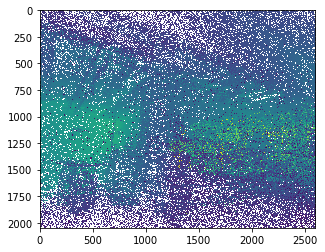

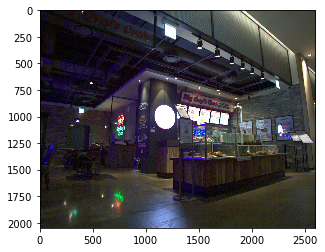

In [51]:
plt.figure()
plt.imshow(query_projected_img[:,:,2])
plt.figure()
plt.imshow(query_img)

In [52]:
temp_result_list = []
temp_dict = {
         'floor': "b1",
         'name': query_image_full_path.split('/')[-1],
         'qw': best_pose[0][3],
         'qx': best_pose[0][0],
         'qy': best_pose[0][1],
         'qz': best_pose[0][2],
         'x': best_pose[1][0][0],
         'y': best_pose[1][0][1],
         'z': best_pose[1][0][2]
}

temp_result_list.append(temp_dict)

In [53]:
with open('20200701_indoor_submit (temp).json', 'w') as outfile:
    json.dump(temp_result_list, outfile)

# Test ALL

In [ ]:
result_list = []
for query_idx in tqdm(range(test_set.dbStruct.q_num)):
    
    try:
        ret_val, query_image_full_path , _, best_pose = VisualLocalization(test_set, query_idx)
    except KeyboardInterrupt: 
        break
    except: 
        continue
        
    if ret_val == True:        
        temp_dict = {
                 'floor': "b1",
                 'name': query_image_full_path.split('/')[-1],
                 'qw': best_pose[0][3],
                 'qx': best_pose[0][0],
                 'qy': best_pose[0][1],
                 'qz': best_pose[0][2],
                 'x': best_pose[1][0][0],
                 'y': best_pose[1][0][1],
                 'z': best_pose[1][0][2]
        }

        result_list.append(temp_dict)

    if (query_idx % 10 == 0):
        with open('20200701_indoor_submit (farm1).json', 'w') as outfile:
            json.dump(result_list, outfile)


  0%|          | 0/1000 [00:00<?, ?it/s]

Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  491
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  772
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  714
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  116
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



  0%|          | 1/1000 [01:07<18:39:50, 67.26s/it]

match_size :  1208
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  412
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  431
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  505
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  507
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



  0%|          | 2/1000 [02:09<18:15:26, 65.86s/it]

match_size :  318
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  677
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  349
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  700
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  134
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



  0%|          | 3/1000 [03:23<18:50:54, 68.06s/it]

match_size :  187
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1043
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  681
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  781
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  467
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



  0%|          | 4/1000 [04:19<17:52:58, 64.64s/it]

match_size :  1154
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  739
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  646
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  513
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  342
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



  0%|          | 5/1000 [05:37<18:55:30, 68.47s/it]

match_size :  336
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



  1%|          | 6/1000 [07:00<20:08:12, 72.93s/it]

match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  492
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  224
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  145
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  542
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



  1%|          | 7/1000 [07:28<16:24:21, 59.48s/it]

match_size :  274
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1236
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  561
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1141
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  803
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



  1%|          | 8/1000 [08:35<16:59:53, 61.69s/it]

match_size :  713
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  666
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  703
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  108
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  80
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



  1%|          | 9/1000 [09:17<15:19:55, 55.70s/it]

match_size :  116
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  2
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  3
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



  1%|          | 10/1000 [10:38<17:24:37, 63.31s/it]

match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1078
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1308
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  648
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  431
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



  1%|          | 11/1000 [12:05<19:21:46, 70.48s/it]

match_size :  264
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1012
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  539
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  461
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  886
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



  1%|          | 12/1000 [14:11<23:53:51, 87.08s/it]

match_size :  691
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  72
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  144
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  15
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  3
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



  1%|▏         | 13/1000 [15:29<23:09:40, 84.48s/it]

match_size :  71
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1003
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  779
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  784
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  656
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



  1%|▏         | 14/1000 [16:30<21:11:32, 77.38s/it]

match_size :  873
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  592
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  421
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  191
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  228
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



  2%|▏         | 15/1000 [17:44<20:54:03, 76.39s/it]

match_size :  359
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  822
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  909
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  793
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  618
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



  2%|▏         | 16/1000 [19:14<22:01:33, 80.58s/it]

match_size :  561
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  568
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  330
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  292
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



  2%|▏         | 17/1000 [20:52<23:24:14, 85.71s/it]

match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  244
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  351
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  16
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  228
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



  2%|▏         | 18/1000 [22:25<23:58:13, 87.88s/it]

match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  568
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  599
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  450
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  683
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



  2%|▏         | 19/1000 [23:21<21:20:36, 78.32s/it]

match_size :  421
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  571
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  334
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  385
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  588
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



  2%|▏         | 20/1000 [24:34<20:51:20, 76.61s/it]

match_size :  709
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  656
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  476
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  487
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  546
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



  2%|▏         | 21/1000 [25:00<16:46:22, 61.68s/it]

match_size :  22
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  440
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  529
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  215
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  325
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



  2%|▏         | 22/1000 [25:31<14:15:00, 52.45s/it]

match_size :  134
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  640
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  226
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  775
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  23
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



  2%|▏         | 23/1000 [26:31<14:50:23, 54.68s/it]

match_size :  90
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  293
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  439
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  379
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  36
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



  2%|▏         | 24/1000 [27:13<13:44:28, 50.69s/it]

match_size :  138
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  783
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  215
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



  2%|▎         | 25/1000 [28:48<17:21:51, 64.11s/it]

match_size :  989
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  481
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  448
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  412
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  636
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



  3%|▎         | 26/1000 [29:50<17:10:38, 63.49s/it]

match_size :  990
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  916
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1101
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  884
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  956
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



  3%|▎         | 27/1000 [30:58<17:33:10, 64.94s/it]

match_size :  661
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  613
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  740
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  150
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  13
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



  3%|▎         | 28/1000 [32:17<18:38:14, 69.03s/it]

match_size :  147
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  14
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  101
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  4
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



  3%|▎         | 29/1000 [33:32<19:05:25, 70.78s/it]

match_size :  16
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  409
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  556
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  796
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  178
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



  3%|▎         | 30/1000 [34:55<20:04:54, 74.53s/it]

match_size :  106
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  529
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1088
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  388
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  697
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



  3%|▎         | 31/1000 [36:12<20:16:24, 75.32s/it]

match_size :  398
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  7
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



  3%|▎         | 32/1000 [37:10<18:49:40, 70.02s/it]

match_size :  4
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  438
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  235
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  455
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  330
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



  3%|▎         | 33/1000 [38:03<17:24:49, 64.83s/it]

match_size :  466
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  578
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  320
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  806
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  334
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



  3%|▎         | 34/1000 [38:42<15:18:56, 57.08s/it]

match_size :  284
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  77
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  380
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  19
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  252
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



  4%|▎         | 35/1000 [39:29<14:28:35, 54.01s/it]

match_size :  94
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  768
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  754
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  30
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  13
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



  4%|▎         | 36/1000 [40:04<12:57:22, 48.38s/it]

match_size :  75
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  62
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  102
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  413
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  10
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



  4%|▎         | 37/1000 [41:26<15:40:45, 58.61s/it]

match_size :  345
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1216
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1127
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1120
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  599
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



  4%|▍         | 38/1000 [42:20<15:15:33, 57.10s/it]

match_size :  727
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  593
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  580
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  816
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



  4%|▍         | 39/1000 [43:28<16:05:53, 60.31s/it]

match_size :  652
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  917
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  616
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  401
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1093
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



  4%|▍         | 40/1000 [44:57<18:26:27, 69.15s/it]

match_size :  39
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  644
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  877
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  449
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  939
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



  4%|▍         | 41/1000 [46:27<20:02:01, 75.21s/it]

match_size :  34
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  630
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  659
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  559
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  854
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



  4%|▍         | 42/1000 [47:31<19:10:12, 72.04s/it]

match_size :  840
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  730
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  585
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  683
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  402
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



  4%|▍         | 43/1000 [48:46<19:19:12, 72.68s/it]

match_size :  763
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  433
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  486
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  484
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  435
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



  4%|▍         | 44/1000 [49:43<18:02:54, 67.96s/it]

match_size :  467
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1111
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  625
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  871
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  653
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



  4%|▍         | 45/1000 [50:40<17:13:20, 64.92s/it]

match_size :  358
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  586
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  478
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  459
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  252
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



  5%|▍         | 46/1000 [51:47<17:19:03, 65.35s/it]

match_size :  571
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  892
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1060
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  898
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  991
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



  5%|▍         | 47/1000 [52:57<17:43:42, 66.97s/it]

match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  631
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  790
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  553
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1148
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



  5%|▍         | 48/1000 [54:04<17:41:36, 66.91s/it]

match_size :  505
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  625
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  718
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  541
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  686
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



  5%|▍         | 49/1000 [55:18<18:11:29, 68.86s/it]

match_size :  134
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  43
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  15
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  3
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



  5%|▌         | 50/1000 [56:27<18:12:57, 69.03s/it]

match_size :  17
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1113
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1137
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1155
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  10
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



  5%|▌         | 51/1000 [57:48<19:08:47, 72.63s/it]

match_size :  15
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  629
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  969
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1250
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  734
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



  5%|▌         | 52/1000 [58:51<18:23:31, 69.84s/it]

match_size :  1218
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  348
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  111
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  170
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  169
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



  5%|▌         | 53/1000 [59:52<17:37:39, 67.01s/it]

match_size :  152
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  850
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  959
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  769
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1010
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



  5%|▌         | 54/1000 [1:01:14<18:47:07, 71.49s/it]

match_size :  581
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  901
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1254
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  791
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  388
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



  6%|▌         | 55/1000 [1:02:15<17:55:13, 68.27s/it]

match_size :  264
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  476
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  349
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  555
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  645
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



  6%|▌         | 56/1000 [1:03:36<18:54:22, 72.10s/it]

match_size :  195
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1167
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  747
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  907
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1109
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



  6%|▌         | 57/1000 [1:04:49<19:00:18, 72.55s/it]

match_size :  1178
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  106
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  368
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  112
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  186
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



  6%|▌         | 58/1000 [1:05:46<17:43:34, 67.74s/it]

match_size :  242
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  813
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  343
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  454
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  677
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



  6%|▌         | 59/1000 [1:06:53<17:40:25, 67.61s/it]

match_size :  635
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  375
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  382
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  282
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  768
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



  6%|▌         | 60/1000 [1:07:45<16:23:53, 62.80s/it]

match_size :  818
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  208
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  66
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  5
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  173
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



  6%|▌         | 61/1000 [1:08:41<15:55:04, 61.03s/it]

match_size :  84
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  228
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  103
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  228
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  269
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



  6%|▌         | 62/1000 [1:09:54<16:48:53, 64.53s/it]

match_size :  95
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1663
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1218
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1047
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  925
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



  6%|▋         | 63/1000 [1:11:03<17:06:19, 65.72s/it]

match_size :  733
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1022
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1137
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1014
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  455
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



  6%|▋         | 64/1000 [1:12:21<18:03:31, 69.46s/it]

match_size :  80
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  653
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  88
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  589
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  449
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



  6%|▋         | 65/1000 [1:13:45<19:11:32, 73.90s/it]

match_size :  374
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  952
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  683
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  945
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  641
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



  7%|▋         | 66/1000 [1:15:11<20:06:45, 77.52s/it]

match_size :  1066
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  710
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  439
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  372
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  580
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



  7%|▋         | 67/1000 [1:15:53<17:20:15, 66.90s/it]

match_size :  606
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  587
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  2
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  28
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



  7%|▋         | 68/1000 [1:16:52<16:40:50, 64.43s/it]

match_size :  77
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  941
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  292
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1056
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  927
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



  7%|▋         | 69/1000 [1:18:06<17:23:21, 67.24s/it]

match_size :  529
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  467
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  573
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  333
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  739
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



  7%|▋         | 70/1000 [1:19:49<20:08:38, 77.98s/it]

match_size :  594
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  455
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  612
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  384
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



  7%|▋         | 71/1000 [1:21:15<20:47:12, 80.55s/it]

match_size :  205
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  814
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  770
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  624
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  440
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



  7%|▋         | 72/1000 [1:22:02<18:08:54, 70.40s/it]

match_size :  978
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  883
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1023
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  949
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  631
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



  7%|▋         | 73/1000 [1:23:32<19:38:01, 76.25s/it]

match_size :  411
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  891
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1114
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  6
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



  7%|▋         | 74/1000 [1:24:40<18:58:58, 73.80s/it]

match_size :  2
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  647
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  96
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  261
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  233
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



  8%|▊         | 75/1000 [1:25:19<16:17:18, 63.39s/it]

match_size :  99
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  633
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  447
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  313
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  431
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



  8%|▊         | 76/1000 [1:26:30<16:52:49, 65.77s/it]

match_size :  281
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  448
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  573
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  370
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1184
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



  8%|▊         | 77/1000 [1:27:52<18:03:04, 70.41s/it]

match_size :  352
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  8
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  6
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  26
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



  8%|▊         | 78/1000 [1:29:00<17:53:04, 69.83s/it]

match_size :  247
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  34
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1097
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  10
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  886
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



  8%|▊         | 79/1000 [1:30:18<18:27:46, 72.17s/it]

match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1149
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1141
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1114
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1152
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



  8%|▊         | 80/1000 [1:31:31<18:33:05, 72.59s/it]

match_size :  1117
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  28
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  15
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  485
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



  8%|▊         | 81/1000 [1:32:22<16:52:05, 66.08s/it]

match_size :  157
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  325
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  146
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  239
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  74
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



  8%|▊         | 82/1000 [1:33:10<15:27:13, 60.60s/it]

match_size :  1
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  736
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  872
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  574
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  527
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



  8%|▊         | 83/1000 [1:34:19<16:03:18, 63.03s/it]

match_size :  762
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1110
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  984
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  871
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  866
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



  8%|▊         | 84/1000 [1:35:28<16:32:46, 65.03s/it]

match_size :  805
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  966
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  833
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1302
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1092
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



  8%|▊         | 85/1000 [1:37:08<19:11:06, 75.48s/it]

match_size :  717
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  319
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  532
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  190
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  341
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



  9%|▊         | 86/1000 [1:38:18<18:43:31, 73.75s/it]

match_size :  1319
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  633
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  557
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  600
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  456
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



  9%|▊         | 87/1000 [1:39:24<18:08:59, 71.57s/it]

match_size :  464
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  56
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  871
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  9
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  161
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



  9%|▉         | 88/1000 [1:40:59<19:50:53, 78.35s/it]

match_size :  11
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  91
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



  9%|▉         | 89/1000 [1:42:10<19:15:50, 76.13s/it]

match_size :  312
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  738
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  466
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  373
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  637
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



  9%|▉         | 90/1000 [1:43:09<18:00:30, 71.24s/it]

match_size :  698
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  9
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  78
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  388
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  397
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



  9%|▉         | 91/1000 [1:43:41<14:59:04, 59.35s/it]

match_size :  272
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  29
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  25
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  37
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  29
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



  9%|▉         | 92/1000 [1:44:58<16:16:45, 64.54s/it]

match_size :  31
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  188
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



  9%|▉         | 93/1000 [1:46:02<16:14:35, 64.47s/it]

match_size :  61
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1138
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  659
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  216
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  524
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



  9%|▉         | 94/1000 [1:46:48<14:48:04, 58.81s/it]

match_size :  100
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  671
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  683
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  589
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  554
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 10%|▉         | 95/1000 [1:47:55<15:27:59, 61.52s/it]

match_size :  581
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1407
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1158
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  979
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  680
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 10%|▉         | 96/1000 [1:48:40<14:10:32, 56.45s/it]

match_size :  568
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  984
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  802
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  780
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  847
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 10%|▉         | 97/1000 [1:50:10<16:41:50, 66.57s/it]

match_size :  573
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1059
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1259
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  664
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  666
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 10%|▉         | 98/1000 [1:51:10<16:10:50, 64.58s/it]

match_size :  768
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  944
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  477
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  454
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  765
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 10%|▉         | 99/1000 [1:52:00<15:04:54, 60.26s/it]

match_size :  751
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1312
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1490
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1318
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1352
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 10%|█         | 100/1000 [1:53:18<16:20:21, 65.36s/it]

match_size :  1221
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1071
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  128
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  292
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  29
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 10%|█         | 101/1000 [1:54:53<18:36:15, 74.50s/it]

match_size :  252
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  616
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  448
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  682
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  26
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 10%|█         | 102/1000 [1:56:03<18:11:38, 72.94s/it]

match_size :  501
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  668
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  413
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  720
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  657
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 10%|█         | 103/1000 [1:57:10<17:44:12, 71.18s/it]

match_size :  716
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  285
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  515
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  32
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  21
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 10%|█         | 104/1000 [1:57:40<14:38:39, 58.84s/it]

match_size :  293
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  931
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1026
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  659
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  886
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 10%|█         | 105/1000 [1:58:53<15:42:22, 63.18s/it]

match_size :  7
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  541
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  313
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  504
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  591
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 11%|█         | 106/1000 [1:59:52<15:22:29, 61.91s/it]

match_size :  278
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  813
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  853
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  698
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  689
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 11%|█         | 107/1000 [2:01:03<16:01:13, 64.58s/it]

match_size :  603
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  529
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  278
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  175
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  111
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 11%|█         | 108/1000 [2:02:12<16:20:21, 65.94s/it]

match_size :  212
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1025
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1284
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  978
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1184
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 11%|█         | 109/1000 [2:03:04<15:18:42, 61.87s/it]

match_size :  735
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1077
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  3
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  584
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 11%|█         | 110/1000 [2:04:19<16:12:32, 65.57s/it]

match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  968
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1120
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  753
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  563
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 11%|█         | 111/1000 [2:05:37<17:06:32, 69.28s/it]

match_size :  672
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  906
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1223
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  885
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  616
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 11%|█         | 112/1000 [2:06:11<14:30:06, 58.79s/it]

match_size :  1342
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  498
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  804
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  432
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  658
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 11%|█▏        | 113/1000 [2:07:34<16:18:59, 66.22s/it]

match_size :  651
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  627
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  620
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  481
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  548
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 11%|█▏        | 114/1000 [2:08:41<16:21:01, 66.43s/it]

match_size :  500
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1024
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  612
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  385
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1107
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 12%|█▏        | 115/1000 [2:09:45<16:09:15, 65.71s/it]

match_size :  224
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  734
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  734
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  314
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  325
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 12%|█▏        | 116/1000 [2:10:27<14:20:05, 58.38s/it]

match_size :  585
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  109
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  119
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  62
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  93
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 12%|█▏        | 117/1000 [2:11:21<14:01:53, 57.21s/it]

match_size :  345
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1047
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  716
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  569
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1116
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 12%|█▏        | 118/1000 [2:12:44<15:54:03, 64.90s/it]

match_size :  940
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  332
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 12%|█▏        | 119/1000 [2:14:02<16:52:15, 68.94s/it]

match_size :  168
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1097
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1077
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  698
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  776
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 12%|█▏        | 120/1000 [2:15:20<17:29:48, 71.58s/it]

match_size :  714
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  744
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  356
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  859
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 12%|█▏        | 121/1000 [2:16:47<18:37:27, 76.28s/it]

match_size :  2
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  564
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  569
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  404
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  475
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 12%|█▏        | 122/1000 [2:17:04<14:14:00, 58.36s/it]

match_size :  472
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  992
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  761
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1142
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1371
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 12%|█▏        | 123/1000 [2:17:58<13:53:34, 57.03s/it]

match_size :  122
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  526
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  157
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 12%|█▏        | 124/1000 [2:18:58<14:04:39, 57.85s/it]

match_size :  251
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1138
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1065
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  890
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  880
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 12%|█▎        | 125/1000 [2:20:30<16:35:40, 68.28s/it]

match_size :  661
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  461
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  511
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  730
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  313
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 13%|█▎        | 126/1000 [2:21:41<16:44:11, 68.94s/it]

match_size :  208
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  635
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  172
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  527
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  493
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 13%|█▎        | 127/1000 [2:23:13<18:24:49, 75.93s/it]

match_size :  546
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  407
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  384
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  440
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  289
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 13%|█▎        | 128/1000 [2:23:47<15:20:36, 63.34s/it]

match_size :  321
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  106
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  101
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 13%|█▎        | 129/1000 [2:24:25<13:28:33, 55.70s/it]

match_size :  121
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  161
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  19
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  13
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 13%|█▎        | 130/1000 [2:25:39<14:49:00, 61.31s/it]

match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  967
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  428
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  287
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  305
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 13%|█▎        | 131/1000 [2:26:08<12:25:59, 51.51s/it]

match_size :  351
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  791
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  454
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  514
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  257
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 13%|█▎        | 132/1000 [2:27:41<15:28:04, 64.15s/it]

match_size :  446
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  110
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  350
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  162
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  225
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 13%|█▎        | 133/1000 [2:28:15<13:16:19, 55.11s/it]

match_size :  137
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1001
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  513
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  362
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  579
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 13%|█▎        | 134/1000 [2:29:35<15:00:19, 62.38s/it]

match_size :  859
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  350
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  110
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  227
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  107
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 14%|█▎        | 135/1000 [2:30:10<13:03:00, 54.31s/it]

match_size :  517
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  853
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  616
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1051
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1024
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 14%|█▎        | 136/1000 [2:31:12<13:35:57, 56.66s/it]

match_size :  554
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  704
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  4
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  5
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 14%|█▎        | 137/1000 [2:32:18<14:15:32, 59.48s/it]

match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  756
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  580
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  475
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  587
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 14%|█▍        | 138/1000 [2:33:28<14:59:42, 62.62s/it]

match_size :  518
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  526
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  412
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  822
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  51
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 14%|█▍        | 139/1000 [2:34:34<15:09:56, 63.41s/it]

match_size :  13
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1340
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  926
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  503
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1331
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 14%|█▍        | 140/1000 [2:35:38<15:13:16, 63.72s/it]

match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  64
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  424
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  16
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  12
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 14%|█▍        | 141/1000 [2:36:40<15:06:02, 63.29s/it]

match_size :  36
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  282
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  210
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  221
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  239
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 14%|█▍        | 142/1000 [2:37:31<14:10:52, 59.50s/it]

match_size :  291
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1164
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1070
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  536
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  418
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 14%|█▍        | 143/1000 [2:38:57<16:02:47, 67.41s/it]

match_size :  869
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  705
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  455
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  236
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  89
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 14%|█▍        | 144/1000 [2:39:24<13:10:06, 55.38s/it]

match_size :  309
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  889
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  589
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  331
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  318
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 14%|█▍        | 145/1000 [2:40:20<13:12:17, 55.60s/it]

match_size :  299
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1138
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  60
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  71
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  528
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 15%|█▍        | 146/1000 [2:41:39<14:51:13, 62.62s/it]

match_size :  82
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  823
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  171
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  3
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  14
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 15%|█▍        | 147/1000 [2:43:09<16:47:06, 70.84s/it]

match_size :  405
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  628
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  68
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  271
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 15%|█▍        | 148/1000 [2:44:28<17:21:01, 73.31s/it]

match_size :  3
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  54
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  41
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  31
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  83
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 15%|█▍        | 149/1000 [2:45:36<16:55:17, 71.58s/it]

match_size :  24
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  987
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1048
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  59
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  32
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 15%|█▌        | 150/1000 [2:46:55<17:27:05, 73.91s/it]

match_size :  34
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  671
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  482
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  562
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  719
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 15%|█▌        | 151/1000 [2:48:28<18:45:52, 79.57s/it]

match_size :  717
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  387
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  84
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 15%|█▌        | 152/1000 [2:49:46<18:38:51, 79.16s/it]

match_size :  64
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  76
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  281
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  181
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  88
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 15%|█▌        | 153/1000 [2:50:35<16:27:05, 69.92s/it]

match_size :  188
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1374
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1532
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  595
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1171
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 15%|█▌        | 154/1000 [2:51:45<16:26:41, 69.98s/it]

match_size :  969
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  89
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  81
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  69
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  175
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 16%|█▌        | 155/1000 [2:52:57<16:35:09, 70.66s/it]

match_size :  628
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  644
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  592
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  717
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  747
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 16%|█▌        | 156/1000 [2:53:55<15:41:24, 66.92s/it]

match_size :  500
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  695
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  688
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  417
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  546
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 16%|█▌        | 157/1000 [2:54:32<13:32:36, 57.84s/it]

match_size :  118
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  705
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  570
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  411
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  850
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 16%|█▌        | 158/1000 [2:55:33<13:47:00, 58.93s/it]

match_size :  464
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  677
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1045
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  851
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  772
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 16%|█▌        | 159/1000 [2:56:58<15:33:57, 66.63s/it]

match_size :  357
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  770
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  868
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  619
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  696
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 16%|█▌        | 160/1000 [2:58:06<15:38:08, 67.01s/it]

match_size :  947
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  122
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  120
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  536
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  103
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 16%|█▌        | 161/1000 [2:59:08<15:17:41, 65.63s/it]

match_size :  446
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  657
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  586
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  770
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  656
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 16%|█▌        | 162/1000 [3:00:35<16:46:31, 72.07s/it]

match_size :  725
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  549
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  774
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  130
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  131
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 16%|█▋        | 163/1000 [3:01:47<16:43:11, 71.91s/it]

match_size :  738
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  990
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  753
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  690
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  912
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 16%|█▋        | 164/1000 [3:03:21<18:16:32, 78.70s/it]

match_size :  938
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  317
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  446
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  425
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  459
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 16%|█▋        | 165/1000 [3:04:28<17:26:33, 75.20s/it]

match_size :  507
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  65
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  162
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  50
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 17%|█▋        | 166/1000 [3:05:27<16:13:49, 70.06s/it]

match_size :  109
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  220
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  56
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  13
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 17%|█▋        | 167/1000 [3:06:27<15:32:59, 67.20s/it]

match_size :  53
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  142
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 17%|█▋        | 168/1000 [3:08:05<17:40:55, 76.51s/it]

match_size :  10
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  747
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1018
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  402
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  548
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 17%|█▋        | 169/1000 [3:08:58<16:00:08, 69.32s/it]

match_size :  641
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1204
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  999
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  784
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  903
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 17%|█▋        | 170/1000 [3:10:11<16:16:19, 70.58s/it]

match_size :  923
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  10
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  968
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 17%|█▋        | 171/1000 [3:11:00<14:42:41, 63.89s/it]

match_size :  341
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  976
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1176
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1181
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1231
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 17%|█▋        | 172/1000 [3:12:11<15:12:18, 66.11s/it]

match_size :  693
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  307
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  120
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  161
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  275
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 17%|█▋        | 173/1000 [3:13:05<14:21:57, 62.54s/it]

match_size :  200
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  752
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  942
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  759
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  786
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 17%|█▋        | 174/1000 [3:13:56<13:31:31, 58.95s/it]

match_size :  888
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  629
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  655
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  533
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1128
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 18%|█▊        | 175/1000 [3:14:54<13:27:38, 58.74s/it]

match_size :  578
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  631
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  698
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  722
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  533
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 18%|█▊        | 176/1000 [3:16:07<14:26:34, 63.10s/it]

match_size :  629
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  459
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  11
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  714
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  11
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 18%|█▊        | 177/1000 [3:17:19<15:00:40, 65.66s/it]

match_size :  481
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  644
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  627
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  853
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  637
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 18%|█▊        | 178/1000 [3:18:23<14:53:47, 65.24s/it]

match_size :  640
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1101
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1052
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  960
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  641
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 18%|█▊        | 179/1000 [3:19:36<15:25:19, 67.62s/it]

match_size :  682
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  291
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  771
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  920
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  307
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 18%|█▊        | 180/1000 [3:20:33<14:40:58, 64.46s/it]

match_size :  259
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  716
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  793
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  272
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  106
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 18%|█▊        | 181/1000 [3:22:12<17:01:11, 74.81s/it]

match_size :  577
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1095
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  828
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  533
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  434
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 18%|█▊        | 182/1000 [3:23:21<16:33:14, 72.85s/it]

match_size :  667
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1005
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  14
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1241
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  12
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 18%|█▊        | 183/1000 [3:24:16<15:22:39, 67.76s/it]

match_size :  1360
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  209
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  13
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 18%|█▊        | 184/1000 [3:25:36<16:10:24, 71.35s/it]

match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  477
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  370
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  541
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  459
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 18%|█▊        | 185/1000 [3:26:13<13:46:56, 60.88s/it]

match_size :  403
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  434
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  552
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  705
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  438
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 19%|█▊        | 186/1000 [3:27:21<14:14:50, 63.01s/it]

match_size :  239
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1008
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  756
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  494
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  483
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 19%|█▊        | 187/1000 [3:28:22<14:08:45, 62.64s/it]

match_size :  300
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  573
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  660
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  372
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  301
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 19%|█▉        | 188/1000 [3:29:09<13:02:20, 57.81s/it]

match_size :  465
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  635
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  684
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  661
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  559
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 19%|█▉        | 189/1000 [3:30:11<13:20:14, 59.20s/it]

match_size :  548
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  262
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  286
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  72
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  29
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 19%|█▉        | 190/1000 [3:31:35<14:58:42, 66.57s/it]

match_size :  347
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  398
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  469
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  661
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  348
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 19%|█▉        | 191/1000 [3:32:38<14:40:36, 65.31s/it]

match_size :  651
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  153
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  137
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  19
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  345
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 19%|█▉        | 192/1000 [3:33:26<13:33:11, 60.39s/it]

match_size :  138
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  46
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  329
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  613
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 19%|█▉        | 193/1000 [3:34:29<13:40:56, 61.04s/it]

match_size :  528
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  641
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  651
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  423
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  347
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 19%|█▉        | 194/1000 [3:35:33<13:51:03, 61.87s/it]

match_size :  386
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  562
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  95
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  112
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  72
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 20%|█▉        | 195/1000 [3:36:34<13:48:39, 61.76s/it]

match_size :  53
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  505
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  370
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  396
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  580
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 20%|█▉        | 196/1000 [3:37:39<13:59:35, 62.66s/it]

match_size :  763
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  832
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  639
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  993
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  87
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 20%|█▉        | 197/1000 [3:39:00<15:13:23, 68.25s/it]

match_size :  429
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1113
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1339
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  432
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  700
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 20%|█▉        | 198/1000 [3:40:10<15:18:18, 68.70s/it]

match_size :  1321
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  227
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  341
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  110
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  220
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 20%|█▉        | 199/1000 [3:40:52<13:29:08, 60.61s/it]

match_size :  132
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  119
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  206
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  55
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  2
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 20%|██        | 200/1000 [3:41:22<11:26:01, 51.45s/it]

match_size :  134
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  472
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  228
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  312
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  121
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 20%|██        | 201/1000 [3:42:06<10:56:36, 49.31s/it]

match_size :  193
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  418
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  326
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  558
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  492
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 20%|██        | 202/1000 [3:43:29<13:11:01, 59.48s/it]

match_size :  327
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  607
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  720
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  799
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  547
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 20%|██        | 203/1000 [3:44:40<13:55:58, 62.93s/it]

match_size :  767
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  3
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  422
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1103
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  21
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 20%|██        | 204/1000 [3:45:37<13:28:46, 60.96s/it]

match_size :  522
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  490
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  413
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  426
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  531
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 20%|██        | 205/1000 [3:47:02<15:02:35, 68.12s/it]

match_size :  344
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  976
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  504
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  523
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  410
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 21%|██        | 206/1000 [3:48:25<16:00:28, 72.58s/it]

match_size :  498
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1013
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  876
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  832
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  849
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 21%|██        | 207/1000 [3:49:25<15:10:11, 68.87s/it]

match_size :  713
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  504
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  393
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  258
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  285
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 21%|██        | 208/1000 [3:50:27<14:44:29, 67.01s/it]

match_size :  105
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  504
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  621
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  518
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  455
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 21%|██        | 209/1000 [3:51:20<13:45:40, 62.63s/it]

match_size :  449
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 21%|██        | 210/1000 [3:52:12<13:04:45, 59.60s/it]

match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  372
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  258
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  281
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  156
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 21%|██        | 211/1000 [3:53:04<12:32:56, 57.26s/it]

match_size :  284
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  29
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  393
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  8
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  343
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 21%|██        | 212/1000 [3:54:05<12:45:35, 58.29s/it]

match_size :  3
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  420
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  105
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  8
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 21%|██▏       | 213/1000 [3:55:27<14:19:09, 65.50s/it]

match_size :  2
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  513
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  366
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  621
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  447
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 21%|██▏       | 214/1000 [3:56:27<13:56:07, 63.83s/it]

match_size :  421
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  507
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  557
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  859
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  313
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 22%|██▏       | 215/1000 [3:57:40<14:30:10, 66.51s/it]

match_size :  6
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  151
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  472
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  51
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 22%|██▏       | 216/1000 [3:58:55<15:03:21, 69.14s/it]

match_size :  357
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  493
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  465
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  489
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  478
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 22%|██▏       | 217/1000 [3:59:39<13:24:15, 61.63s/it]

match_size :  587
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  291
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  126
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 22%|██▏       | 218/1000 [4:00:58<14:29:19, 66.70s/it]

match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  321
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  815
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  393
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  305
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 22%|██▏       | 219/1000 [4:02:19<15:24:44, 71.04s/it]

match_size :  707
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  871
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  401
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  944
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  736
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 22%|██▏       | 220/1000 [4:03:41<16:05:38, 74.28s/it]

match_size :  882
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  756
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  556
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  583
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  627
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 22%|██▏       | 221/1000 [4:04:48<15:36:56, 72.16s/it]

match_size :  914
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1223
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  810
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  808
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  796
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 22%|██▏       | 222/1000 [4:06:09<16:08:40, 74.71s/it]

match_size :  928
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  692
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  521
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  689
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  145
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 22%|██▏       | 223/1000 [4:07:41<17:14:26, 79.88s/it]

match_size :  41
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  689
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  472
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  336
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  295
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 22%|██▏       | 224/1000 [4:08:25<14:55:23, 69.23s/it]

match_size :  20
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  157
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  174
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  127
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  57
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 22%|██▎       | 225/1000 [4:09:33<14:47:46, 68.73s/it]

match_size :  112
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  543
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  205
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  297
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  368
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 23%|██▎       | 226/1000 [4:10:16<13:09:02, 61.17s/it]

match_size :  141
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  121
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  6
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  158
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  90
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 23%|██▎       | 227/1000 [4:11:40<14:37:28, 68.11s/it]

match_size :  12
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  552
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  608
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  461
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  2
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 23%|██▎       | 228/1000 [4:12:18<12:37:39, 58.88s/it]

match_size :  351
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  546
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  626
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  721
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 23%|██▎       | 229/1000 [4:13:16<12:35:19, 58.78s/it]

match_size :  768
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  233
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  552
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  838
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  71
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 23%|██▎       | 230/1000 [4:14:30<13:32:20, 63.30s/it]

match_size :  8
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  8
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  13
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  43
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  136
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 23%|██▎       | 231/1000 [4:15:31<13:21:25, 62.53s/it]

match_size :  20
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  260
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  453
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  2
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  342
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 23%|██▎       | 232/1000 [4:16:29<13:04:24, 61.28s/it]

match_size :  55
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  387
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  9
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  336
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  319
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 23%|██▎       | 233/1000 [4:17:53<14:27:30, 67.86s/it]

match_size :  52
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  358
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  386
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  309
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  356
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 23%|██▎       | 234/1000 [4:18:47<13:34:03, 63.76s/it]

match_size :  192
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  359
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  258
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  252
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 24%|██▎       | 235/1000 [4:19:33<12:27:25, 58.62s/it]

match_size :  200
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  127
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  18
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  58
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  281
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 24%|██▎       | 236/1000 [4:20:36<12:41:44, 59.82s/it]

match_size :  9
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  279
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  502
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  47
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  219
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 24%|██▎       | 237/1000 [4:21:45<13:17:08, 62.68s/it]

match_size :  34
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  65
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 24%|██▍       | 238/1000 [4:22:52<13:32:24, 63.97s/it]

match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  141
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  6
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 24%|██▍       | 239/1000 [4:23:32<11:58:02, 56.61s/it]

match_size :  8
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  161
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  199
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  325
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  3
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 24%|██▍       | 240/1000 [4:24:40<12:43:05, 60.24s/it]

match_size :  230
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  462
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  526
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  3
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 24%|██▍       | 241/1000 [4:25:51<13:19:44, 63.22s/it]

match_size :  9
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1574
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1390
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1239
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  925
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 24%|██▍       | 242/1000 [4:26:34<12:03:45, 57.29s/it]

match_size :  1294
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  279
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  254
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  242
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  98
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 24%|██▍       | 243/1000 [4:27:54<13:29:48, 64.19s/it]

match_size :  218
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  591
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  364
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  362
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 24%|██▍       | 244/1000 [4:28:49<12:52:02, 61.27s/it]

match_size :  565
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  229
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  845
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  518
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  128
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 24%|██▍       | 245/1000 [4:29:59<13:24:52, 63.96s/it]

match_size :  117
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  227
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  237
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  241
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  74
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 25%|██▍       | 246/1000 [4:31:01<13:17:40, 63.47s/it]

match_size :  17
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  291
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  371
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  354
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  342
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 25%|██▍       | 247/1000 [4:32:08<13:28:13, 64.40s/it]

match_size :  575
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  21
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  517
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  41
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  269
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 25%|██▍       | 248/1000 [4:33:32<14:39:30, 70.17s/it]

match_size :  278
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  469
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  613
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  541
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  469
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 25%|██▍       | 249/1000 [4:35:03<15:56:18, 76.40s/it]

match_size :  379
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  528
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  473
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  348
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 25%|██▌       | 250/1000 [4:35:41<13:33:54, 65.11s/it]

match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  2
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  6
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  32
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  807
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 25%|██▌       | 251/1000 [4:36:59<14:20:27, 68.93s/it]

match_size :  625
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  657
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  605
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  659
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  342
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 25%|██▌       | 252/1000 [4:38:00<13:48:56, 66.49s/it]

match_size :  509
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  256
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  141
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  10
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  86
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 25%|██▌       | 253/1000 [4:38:25<11:14:13, 54.15s/it]

match_size :  53
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  406
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  414
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  93
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  207
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 25%|██▌       | 254/1000 [4:39:03<10:13:17, 49.33s/it]

match_size :  185
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  777
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  115
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  528
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  4
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 26%|██▌       | 255/1000 [4:40:28<12:23:56, 59.92s/it]

match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  144
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  55
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  208
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 26%|██▌       | 256/1000 [4:40:55<10:22:13, 50.18s/it]

match_size :  163
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  618
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  203
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  420
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  10
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 26%|██▌       | 257/1000 [4:41:49<10:34:45, 51.26s/it]

match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  623
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  581
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  645
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  610
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 26%|██▌       | 258/1000 [4:43:09<12:19:15, 59.78s/it]

match_size :  481
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  193
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 26%|██▌       | 259/1000 [4:44:06<12:07:23, 58.90s/it]

match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  671
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  463
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  672
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  784
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 26%|██▌       | 260/1000 [4:45:33<13:49:41, 67.27s/it]

match_size :  245
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  5
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  402
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 26%|██▌       | 261/1000 [4:46:30<13:12:34, 64.35s/it]

match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  351
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  12
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  4
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 26%|██▌       | 262/1000 [4:47:24<12:34:25, 61.34s/it]

match_size :  5
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  320
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  172
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  200
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  40
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 26%|██▋       | 263/1000 [4:47:54<10:38:05, 51.95s/it]

match_size :  15
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  712
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  720
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  438
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  676
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 26%|██▋       | 264/1000 [4:49:15<12:21:20, 60.44s/it]

match_size :  686
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  71
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 26%|██▋       | 265/1000 [4:50:31<13:17:49, 65.13s/it]

match_size :  10
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  400
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  180
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  629
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  615
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 27%|██▋       | 266/1000 [4:51:20<12:18:03, 60.33s/it]

match_size :  675
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1124
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  794
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  759
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  698
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 27%|██▋       | 267/1000 [4:52:13<11:50:29, 58.16s/it]

match_size :  151
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  559
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  407
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  452
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  655
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 27%|██▋       | 268/1000 [4:53:25<12:38:31, 62.17s/it]

match_size :  372
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  758
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  589
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  746
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  735
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 27%|██▋       | 269/1000 [4:54:58<14:33:15, 71.68s/it]

match_size :  540
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1386
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1042
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  884
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1028
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 27%|██▋       | 270/1000 [4:55:52<13:25:44, 66.23s/it]

match_size :  873
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  15
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  17
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 27%|██▋       | 271/1000 [4:56:42<12:26:44, 61.46s/it]

match_size :  1
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  15
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  351
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  4
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  14
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 27%|██▋       | 272/1000 [4:57:04<10:01:57, 49.61s/it]

match_size :  1
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  944
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  740
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  710
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 27%|██▋       | 273/1000 [4:58:06<10:45:24, 53.27s/it]

match_size :  1
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 27%|██▋       | 274/1000 [4:59:24<12:15:34, 60.79s/it]

match_size :  79
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 28%|██▊       | 275/1000 [5:00:03<10:55:06, 54.22s/it]

match_size :  109
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  486
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  515
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  452
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  346
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 28%|██▊       | 276/1000 [5:00:36<9:35:25, 47.69s/it] 

match_size :  412
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1016
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  120
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  776
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  870
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 28%|██▊       | 277/1000 [5:01:43<10:47:22, 53.72s/it]

match_size :  781
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  610
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  345
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  299
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  379
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 28%|██▊       | 278/1000 [5:03:14<13:00:37, 64.87s/it]

match_size :  637
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  573
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  279
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  131
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  11
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 28%|██▊       | 279/1000 [5:03:56<11:34:04, 57.76s/it]

match_size :  92
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  323
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  93
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  44
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 28%|██▊       | 280/1000 [5:04:48<11:14:50, 56.24s/it]

match_size :  104
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  535
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  5
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  474
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  994
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 28%|██▊       | 281/1000 [5:06:10<12:46:12, 63.94s/it]

match_size :  30
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  78
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  26
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  48
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  11
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 28%|██▊       | 282/1000 [5:06:57<11:44:37, 58.88s/it]

match_size :  104
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  259
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  20
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  353
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  17
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 28%|██▊       | 283/1000 [5:08:17<12:58:56, 65.18s/it]

match_size :  481
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  830
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  288
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  444
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  532
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 28%|██▊       | 284/1000 [5:09:36<13:47:27, 69.34s/it]

match_size :  7
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  495
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  488
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  516
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  198
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 28%|██▊       | 285/1000 [5:10:28<12:44:38, 64.17s/it]

match_size :  2
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1748
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1428
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  290
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  32
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 29%|██▊       | 286/1000 [5:11:13<11:33:52, 58.31s/it]

match_size :  504
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  534
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  544
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  138
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1101
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 29%|██▊       | 287/1000 [5:11:44<9:57:24, 50.27s/it] 

match_size :  269
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  424
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  494
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  571
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  503
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 29%|██▉       | 288/1000 [5:13:10<12:01:59, 60.84s/it]

match_size :  169
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  13
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 29%|██▉       | 289/1000 [5:14:25<12:52:25, 65.18s/it]

match_size :  1
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  317
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  147
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  586
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  50
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 29%|██▉       | 290/1000 [5:15:43<13:37:03, 69.05s/it]

match_size :  35
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  28
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  74
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  146
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 29%|██▉       | 291/1000 [5:16:51<13:32:08, 68.73s/it]

match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  506
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  122
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  589
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  170
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 29%|██▉       | 292/1000 [5:17:50<12:56:08, 65.77s/it]

match_size :  157
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1124
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  837
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  539
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  670
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 29%|██▉       | 293/1000 [5:18:58<13:02:52, 66.44s/it]

match_size :  703
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  453
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  571
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  513
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  425
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 29%|██▉       | 294/1000 [5:20:30<14:31:21, 74.05s/it]

match_size :  365
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 30%|██▉       | 295/1000 [5:21:47<14:42:26, 75.10s/it]

match_size :  2
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  94
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  64
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  30
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 30%|██▉       | 296/1000 [5:22:58<14:26:26, 73.84s/it]

match_size :  10
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  41
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  155
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  140
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 30%|██▉       | 297/1000 [5:24:11<14:19:33, 73.36s/it]

match_size :  20
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  26
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  7
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  765
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  25
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 30%|██▉       | 298/1000 [5:25:24<14:16:47, 73.23s/it]

match_size :  1
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  714
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  408
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  376
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  88
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 30%|██▉       | 299/1000 [5:26:06<12:26:24, 63.89s/it]

match_size :  357
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  360
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  307
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  203
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  229
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 30%|███       | 300/1000 [5:26:32<10:12:36, 52.51s/it]

match_size :  340
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  199
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  138
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 30%|███       | 301/1000 [5:27:33<10:43:42, 55.25s/it]

match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  625
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  584
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  497
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  321
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 30%|███       | 302/1000 [5:28:31<10:52:32, 56.09s/it]

match_size :  335
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  209
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  161
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  174
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  78
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 30%|███       | 303/1000 [5:29:16<10:13:36, 52.82s/it]

match_size :  164
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  716
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  132
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  614
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  444
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 30%|███       | 304/1000 [5:30:13<10:26:01, 53.97s/it]

match_size :  139
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  226
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  410
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  215
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  4
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 30%|███       | 305/1000 [5:30:52<9:34:20, 49.58s/it] 

match_size :  3
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  133
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  260
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  183
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  161
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 31%|███       | 306/1000 [5:32:05<10:51:29, 56.32s/it]

match_size :  124
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  14
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  3
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  101
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  3
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 31%|███       | 307/1000 [5:33:27<12:21:13, 64.18s/it]

match_size :  5
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  173
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  12
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  904
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  386
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 31%|███       | 308/1000 [5:34:45<13:07:42, 68.30s/it]

match_size :  845
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1040
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  626
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  416
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  55
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 31%|███       | 309/1000 [5:35:52<13:00:33, 67.78s/it]

match_size :  1013
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 31%|███       | 310/1000 [5:37:04<13:15:06, 69.14s/it]

match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  26
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 31%|███       | 311/1000 [5:38:28<14:06:28, 73.71s/it]

match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  738
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  297
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  4
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 31%|███       | 312/1000 [5:39:25<13:08:42, 68.78s/it]

match_size :  492
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1032
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  933
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  2
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  19
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 31%|███▏      | 313/1000 [5:40:42<13:34:50, 71.17s/it]

match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  806
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  743
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  809
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  756
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 31%|███▏      | 314/1000 [5:41:40<12:48:47, 67.24s/it]

match_size :  1016
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  659
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  552
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  119
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  131
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 32%|███▏      | 315/1000 [5:42:48<12:50:48, 67.52s/it]

match_size :  82
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  12
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  4
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  378
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 32%|███▏      | 316/1000 [5:44:04<13:18:09, 70.01s/it]

match_size :  649
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1481
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1085
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1494
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1118
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 32%|███▏      | 317/1000 [5:45:06<12:50:16, 67.67s/it]

match_size :  1105
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1357
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1468
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  820
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  767
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 32%|███▏      | 318/1000 [5:46:04<12:15:42, 64.73s/it]

match_size :  802
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 32%|███▏      | 319/1000 [5:47:05<12:02:09, 63.63s/it]

match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  41
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  13
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  97
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  218
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 32%|███▏      | 320/1000 [5:48:18<12:30:24, 66.21s/it]

match_size :  53
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1249
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  547
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  403
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  681
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 32%|███▏      | 321/1000 [5:48:56<10:54:29, 57.83s/it]

match_size :  584
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  413
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  711
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  195
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  575
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 32%|███▏      | 322/1000 [5:49:54<10:53:49, 57.86s/it]

match_size :  171
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  33
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  49
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  51
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  45
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 32%|███▏      | 323/1000 [5:50:58<11:15:03, 59.83s/it]

match_size :  63
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  596
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  91
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  44
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  33
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 32%|███▏      | 324/1000 [5:51:48<10:38:40, 56.69s/it]

match_size :  152
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  83
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  96
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 32%|███▎      | 325/1000 [5:53:04<11:42:28, 62.44s/it]

match_size :  1
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  620
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  485
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1435
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  59
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 33%|███▎      | 326/1000 [5:54:01<11:23:04, 60.81s/it]

match_size :  185
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  80
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 33%|███▎      | 327/1000 [5:55:02<11:24:25, 61.02s/it]

match_size :  101
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  758
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  790
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  366
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  382
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 33%|███▎      | 328/1000 [5:56:17<12:08:48, 65.07s/it]

match_size :  830
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  405
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  162
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  378
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 33%|███▎      | 329/1000 [5:56:57<10:45:14, 57.70s/it]

match_size :  188
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1337
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  924
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  825
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  790
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 33%|███▎      | 330/1000 [5:57:59<10:57:44, 58.90s/it]

match_size :  783
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  70
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  261
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  47
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  36
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 33%|███▎      | 331/1000 [5:59:05<11:22:10, 61.18s/it]

match_size :  820
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  2
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  125
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  295
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  10
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 33%|███▎      | 332/1000 [6:00:08<11:24:45, 61.50s/it]

match_size :  1
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  353
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  38
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  78
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  13
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 33%|███▎      | 333/1000 [6:01:28<12:28:34, 67.34s/it]

match_size :  489
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  839
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1256
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  57
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 33%|███▎      | 334/1000 [6:02:15<11:18:05, 61.09s/it]

match_size :  50
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1003
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1104
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  860
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  832
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 34%|███▎      | 335/1000 [6:03:27<11:54:39, 64.48s/it]

match_size :  700
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  239
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  172
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  180
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 34%|███▎      | 336/1000 [6:04:16<11:01:21, 59.76s/it]

match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  279
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  133
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  117
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  961
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 34%|███▎      | 337/1000 [6:05:10<10:40:16, 57.94s/it]

match_size :  117
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  520
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  550
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  533
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  432
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 34%|███▍      | 338/1000 [6:06:04<10:27:45, 56.90s/it]

match_size :  459
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  59
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  5
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  2
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  171
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 34%|███▍      | 339/1000 [6:06:51<9:51:38, 53.70s/it] 

match_size :  1
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  556
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  798
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  599
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  178
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 34%|███▍      | 340/1000 [6:08:09<11:14:03, 61.28s/it]

match_size :  783
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1018
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1486
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1172
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  839
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 34%|███▍      | 341/1000 [6:08:47<9:55:32, 54.22s/it] 

match_size :  1245
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  818
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  446
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  31
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  39
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 34%|███▍      | 342/1000 [6:10:11<11:33:22, 63.23s/it]

match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  446
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  754
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  703
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  381
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 34%|███▍      | 343/1000 [6:11:20<11:49:33, 64.80s/it]

match_size :  670
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  287
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  150
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  21
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  195
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 34%|███▍      | 344/1000 [6:12:18<11:27:30, 62.88s/it]

match_size :  86
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  284
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  287
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  344
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  237
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 34%|███▍      | 345/1000 [6:13:17<11:12:12, 61.58s/it]

match_size :  356
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  31
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 35%|███▍      | 346/1000 [6:14:30<11:49:34, 65.10s/it]

match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  68
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  113
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  22
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 35%|███▍      | 347/1000 [6:15:53<12:46:00, 70.38s/it]

match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  244
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  499
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  735
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  520
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 35%|███▍      | 348/1000 [6:16:41<11:32:48, 63.76s/it]

match_size :  89
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1113
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  690
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  321
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  520
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 35%|███▍      | 349/1000 [6:17:23<10:21:28, 57.28s/it]

match_size :  698
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  67
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  56
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  12
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 35%|███▌      | 350/1000 [6:18:36<11:11:37, 62.00s/it]

match_size :  2
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  285
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  135
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  144
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  101
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 35%|███▌      | 351/1000 [6:19:11<9:42:43, 53.87s/it] 

match_size :  151
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  817
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  773
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  795
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  877
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 35%|███▌      | 352/1000 [6:20:38<11:26:49, 63.60s/it]

match_size :  761
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  9
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 35%|███▌      | 353/1000 [6:21:24<10:31:10, 58.53s/it]

match_size :  91
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  656
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  569
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  478
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 35%|███▌      | 354/1000 [6:22:14<10:03:12, 56.03s/it]

match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  517
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  517
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 36%|███▌      | 355/1000 [6:23:23<10:43:16, 59.84s/it]

match_size :  509
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  28
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 36%|███▌      | 356/1000 [6:24:39<11:32:02, 64.48s/it]

match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1067
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  871
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1046
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  106
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 36%|███▌      | 357/1000 [6:25:33<10:59:18, 61.52s/it]

match_size :  121
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  891
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  541
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  809
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  156
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 36%|███▌      | 358/1000 [6:26:43<11:26:33, 64.16s/it]

match_size :  106
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  234
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  5
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 36%|███▌      | 359/1000 [6:27:43<11:12:08, 62.92s/it]

match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  243
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  239
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  236
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  226
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 36%|███▌      | 360/1000 [6:29:04<12:06:00, 68.06s/it]

match_size :  161
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  40
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  26
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  453
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 36%|███▌      | 361/1000 [6:30:00<11:27:07, 64.52s/it]

match_size :  9
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  613
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  763
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  398
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  712
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 36%|███▌      | 362/1000 [6:31:26<12:34:18, 70.94s/it]

match_size :  174
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  709
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  527
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  556
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  433
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 36%|███▋      | 363/1000 [6:32:35<12:29:01, 70.55s/it]

match_size :  464
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  463
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  209
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  825
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  379
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 36%|███▋      | 364/1000 [6:33:50<12:41:36, 71.85s/it]

match_size :  187
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  695
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  788
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  187
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  432
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 36%|███▋      | 365/1000 [6:34:53<12:10:31, 69.03s/it]

match_size :  62
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  436
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  7
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  371
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  237
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 37%|███▋      | 366/1000 [6:35:28<10:21:59, 58.86s/it]

match_size :  14
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  82
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  69
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  51
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 37%|███▋      | 367/1000 [6:36:07<9:19:09, 53.00s/it] 

match_size :  110
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  122
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  18
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  49
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 37%|███▋      | 368/1000 [6:37:30<10:51:09, 61.82s/it]

match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  257
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  129
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  102
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  873
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 37%|███▋      | 369/1000 [6:38:53<11:59:03, 68.37s/it]

match_size :  714
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  103
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  267
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  44
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  24
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 37%|███▋      | 370/1000 [6:39:24<9:58:37, 57.01s/it] 

match_size :  120
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  5
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 37%|███▋      | 371/1000 [6:40:31<10:29:59, 60.09s/it]

match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1156
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  768
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  967
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  809
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 37%|███▋      | 372/1000 [6:41:54<11:41:13, 67.00s/it]

match_size :  1092
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  250
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  764
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  103
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  212
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 37%|███▋      | 373/1000 [6:42:44<10:45:20, 61.76s/it]

match_size :  134
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  370
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  395
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  253
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  661
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 37%|███▋      | 374/1000 [6:43:59<11:26:01, 65.75s/it]

match_size :  574
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  884
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1036
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  793
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  581
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 38%|███▊      | 375/1000 [6:45:14<11:55:43, 68.71s/it]

match_size :  1054
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  236
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 38%|███▊      | 376/1000 [6:46:01<10:45:47, 62.10s/it]

match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1041
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  480
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  471
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1099
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 38%|███▊      | 377/1000 [6:47:00<10:36:08, 61.27s/it]

match_size :  854
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  535
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  617
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  445
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  318
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 38%|███▊      | 378/1000 [6:48:25<11:46:58, 68.20s/it]

match_size :  367
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  453
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  207
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  443
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 38%|███▊      | 379/1000 [6:49:50<12:39:22, 73.37s/it]

match_size :  390
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  538
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  453
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  69
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  459
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 38%|███▊      | 380/1000 [6:50:43<11:33:39, 67.13s/it]

match_size :  267
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  143
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  22
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  39
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 38%|███▊      | 381/1000 [6:51:55<11:48:35, 68.68s/it]

match_size :  300
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  169
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  400
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  349
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  87
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 38%|███▊      | 382/1000 [6:53:02<11:41:22, 68.09s/it]

match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  421
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  583
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  563
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  543
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 38%|███▊      | 383/1000 [6:53:47<10:29:27, 61.21s/it]

match_size :  539
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1058
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  902
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  822
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  607
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 38%|███▊      | 384/1000 [6:54:57<10:56:19, 63.93s/it]

match_size :  1099
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  631
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  614
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  381
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  537
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 38%|███▊      | 385/1000 [6:55:56<10:39:26, 62.39s/it]

match_size :  3
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  983
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1021
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1214
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  875
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 39%|███▊      | 386/1000 [6:56:35<9:26:08, 55.32s/it] 

match_size :  1298
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  434
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  429
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  459
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  199
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 39%|███▊      | 387/1000 [6:58:05<11:11:26, 65.72s/it]

match_size :  785
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  369
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  253
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  288
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  391
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 39%|███▉      | 388/1000 [6:59:25<11:56:14, 70.22s/it]

match_size :  407
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1130
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  997
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  725
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1434
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 39%|███▉      | 389/1000 [7:00:00<10:06:46, 59.59s/it]

match_size :  875
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  645
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  463
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  339
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  327
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 39%|███▉      | 390/1000 [7:01:12<10:41:36, 63.11s/it]

match_size :  626
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  317
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  463
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  405
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  169
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 39%|███▉      | 391/1000 [7:02:14<10:37:06, 62.77s/it]

match_size :  163
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  251
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  98
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  179
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  275
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 39%|███▉      | 392/1000 [7:02:49<9:13:25, 54.61s/it] 

match_size :  254
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1112
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1200
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  339
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  990
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 39%|███▉      | 393/1000 [7:03:12<7:34:45, 44.95s/it]

match_size :  597
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  877
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  640
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  381
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  96
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 39%|███▉      | 394/1000 [7:04:16<8:33:26, 50.84s/it]

match_size :  434
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 40%|███▉      | 395/1000 [7:05:34<9:53:59, 58.91s/it]

match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  258
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  430
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  156
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  119
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 40%|███▉      | 396/1000 [7:06:33<9:53:10, 58.93s/it]

match_size :  222
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  497
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  388
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  286
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  60
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 40%|███▉      | 397/1000 [7:07:57<11:09:23, 66.61s/it]

match_size :  3
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  766
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  625
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  653
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  281
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 40%|███▉      | 398/1000 [7:09:26<12:16:00, 73.36s/it]

match_size :  12
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  245
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  210
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  136
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  17
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 40%|███▉      | 399/1000 [7:10:17<11:07:24, 66.63s/it]

match_size :  242
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  46
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  187
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 40%|████      | 400/1000 [7:11:40<11:53:49, 71.38s/it]

match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  76
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  147
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  57
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 40%|████      | 401/1000 [7:12:40<11:18:06, 67.92s/it]

match_size :  36
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1209
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  192
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1069
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  840
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 40%|████      | 402/1000 [7:13:50<11:23:58, 68.63s/it]

match_size :  65
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  493
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  740
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  524
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  594
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 40%|████      | 403/1000 [7:14:57<11:19:21, 68.28s/it]

match_size :  671
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  100
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  152
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  151
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  582
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 40%|████      | 404/1000 [7:16:18<11:54:09, 71.89s/it]

match_size :  108
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  448
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  679
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  333
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  402
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 40%|████      | 405/1000 [7:17:28<11:47:55, 71.39s/it]

match_size :  332
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  265
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  341
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  273
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  146
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 41%|████      | 406/1000 [7:18:33<11:27:14, 69.42s/it]

match_size :  279
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  497
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  495
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  305
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  488
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 41%|████      | 407/1000 [7:19:15<10:06:53, 61.40s/it]

match_size :  385
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  805
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  711
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  472
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 41%|████      | 408/1000 [7:20:46<11:32:14, 70.16s/it]

match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  758
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1013
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  732
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  138
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 41%|████      | 409/1000 [7:21:43<10:53:09, 66.31s/it]

match_size :  200
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  415
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  802
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  812
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1210
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 41%|████      | 410/1000 [7:22:55<11:09:05, 68.04s/it]

match_size :  729
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1322
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1059
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1145
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  985
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 41%|████      | 411/1000 [7:23:22<9:06:29, 55.67s/it] 

match_size :  1038
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  336
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  48
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  652
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  409
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 41%|████      | 412/1000 [7:23:50<7:42:50, 47.23s/it]

match_size :  109
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  862
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  790
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  504
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  31
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 41%|████▏     | 413/1000 [7:24:35<7:37:17, 46.74s/it]

match_size :  34
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  768
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1107
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  633
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  502
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 41%|████▏     | 414/1000 [7:25:52<9:04:03, 55.71s/it]

match_size :  969
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  821
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  493
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  657
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  405
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 42%|████▏     | 415/1000 [7:27:02<9:45:32, 60.06s/it]

match_size :  823
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  94
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 42%|████▏     | 416/1000 [7:27:59<9:35:53, 59.17s/it]

match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  70
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  702
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  5
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  506
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 42%|████▏     | 417/1000 [7:29:10<10:07:40, 62.54s/it]

match_size :  433
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  797
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  202
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  366
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  906
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 42%|████▏     | 418/1000 [7:30:32<11:03:06, 68.36s/it]

match_size :  259
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  488
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  538
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  598
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  734
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 42%|████▏     | 419/1000 [7:31:43<11:09:46, 69.17s/it]

match_size :  730
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  69
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  571
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  13
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  30
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 42%|████▏     | 420/1000 [7:32:52<11:07:33, 69.06s/it]

match_size :  34
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  407
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  414
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  137
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  17
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 42%|████▏     | 421/1000 [7:34:04<11:16:38, 70.12s/it]

match_size :  85
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  483
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  497
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  567
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  318
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 42%|████▏     | 422/1000 [7:34:27<8:59:13, 55.98s/it] 

match_size :  450
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  603
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  43
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  61
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  632
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 42%|████▏     | 423/1000 [7:35:16<8:37:06, 53.77s/it]

match_size :  113
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  351
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 42%|████▏     | 424/1000 [7:36:21<9:10:17, 57.32s/it]

match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  484
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  505
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  910
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  343
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 42%|████▎     | 425/1000 [7:37:43<10:18:58, 64.59s/it]

match_size :  1050
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  820
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  828
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  817
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  444
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 43%|████▎     | 426/1000 [7:38:58<10:48:47, 67.82s/it]

match_size :  805
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  258
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 43%|████▎     | 427/1000 [7:39:54<10:11:54, 64.07s/it]

match_size :  4
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  26
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  248
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 43%|████▎     | 428/1000 [7:41:19<11:11:04, 70.39s/it]

match_size :  1
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  9
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  26
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  17
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 43%|████▎     | 429/1000 [7:42:16<10:32:58, 66.51s/it]

match_size :  1
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1257
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  806
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  866
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  946
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  798



 43%|████▎     | 430/1000 [7:43:17<10:16:44, 64.92s/it]

Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1395
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1040
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  573
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  851
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 43%|████▎     | 431/1000 [7:44:23<10:17:37, 65.13s/it]

match_size :  476
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  349
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  25
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  496
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  197
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 43%|████▎     | 432/1000 [7:45:28<10:17:12, 65.20s/it]

match_size :  80
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1107
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  646
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  966
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1556
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 43%|████▎     | 433/1000 [7:46:12<9:13:51, 58.61s/it] 

match_size :  1356
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  892
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  834
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  724
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  609
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 43%|████▎     | 434/1000 [7:47:18<9:33:36, 60.81s/it]

match_size :  815
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  252
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  173
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  133
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  47
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 44%|████▎     | 435/1000 [7:48:18<9:31:13, 60.66s/it]

match_size :  46
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  49
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  403
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  510
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  38
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 44%|████▎     | 436/1000 [7:49:09<9:02:05, 57.67s/it]

match_size :  67
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  378
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  377
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  251
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  641
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 44%|████▎     | 437/1000 [7:50:27<9:58:17, 63.76s/it]

match_size :  258
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  48
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  32
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  144
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 44%|████▍     | 438/1000 [7:51:24<9:38:26, 61.76s/it]

match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1293
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1037
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  916
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  923
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 44%|████▍     | 439/1000 [7:52:05<8:39:02, 55.51s/it]

match_size :  969
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  449
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  364
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  218
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  340
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 44%|████▍     | 440/1000 [7:52:55<8:23:45, 53.97s/it]

match_size :  37
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  544
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  397
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  386
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  820
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 44%|████▍     | 441/1000 [7:53:25<7:15:08, 46.71s/it]

match_size :  187
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  635
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  283
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  204
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  281
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 44%|████▍     | 442/1000 [7:54:37<8:24:40, 54.27s/it]

match_size :  7
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  489
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  505
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  501
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  449
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 44%|████▍     | 443/1000 [7:56:06<10:02:49, 64.94s/it]

match_size :  33
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1201
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1050
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  774
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  502
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 44%|████▍     | 444/1000 [7:57:22<10:31:02, 68.10s/it]

match_size :  209
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  44
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  65
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  23
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  17
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 44%|████▍     | 445/1000 [7:58:06<9:24:19, 61.01s/it] 

match_size :  22
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  806
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  556
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  206
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  707
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 45%|████▍     | 446/1000 [7:58:53<8:42:33, 56.59s/it]

match_size :  257
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  507
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  617
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  591
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  820
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 45%|████▍     | 447/1000 [8:00:16<9:56:52, 64.76s/it]

match_size :  358
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  450
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  576
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  785
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  504
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 45%|████▍     | 448/1000 [8:01:33<10:28:29, 68.31s/it]

match_size :  271
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  556
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  452
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  438
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  413
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 45%|████▍     | 449/1000 [8:02:12<9:07:44, 59.65s/it] 

match_size :  406
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  444
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  264
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  238
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  111
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 45%|████▌     | 450/1000 [8:03:23<9:36:11, 62.86s/it]

match_size :  253
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  206
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  461
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  107
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  230
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 45%|████▌     | 451/1000 [8:04:50<10:42:31, 70.22s/it]

match_size :  268
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  716
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  323
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  20
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 45%|████▌     | 452/1000 [8:05:47<10:04:03, 66.14s/it]

match_size :  27
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  597
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  581
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  390
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  912
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 45%|████▌     | 453/1000 [8:07:02<10:28:36, 68.95s/it]

match_size :  159
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  423
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  320
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  354
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  293
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 45%|████▌     | 454/1000 [8:08:07<10:16:08, 67.71s/it]

match_size :  806
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  6
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  20
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  3
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 46%|████▌     | 455/1000 [8:08:58<9:28:04, 62.54s/it] 

match_size :  39
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  195
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  232
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  242
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 46%|████▌     | 456/1000 [8:10:14<10:04:46, 66.70s/it]

match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  878
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  928
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  509
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  397
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 46%|████▌     | 457/1000 [8:11:30<10:29:28, 69.55s/it]

match_size :  605
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  2
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  4
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  3
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 46%|████▌     | 458/1000 [8:12:40<10:30:05, 69.75s/it]

match_size :  1
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  167
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  68
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  99
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  141
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 46%|████▌     | 459/1000 [8:13:55<10:41:04, 71.10s/it]

match_size :  48
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  121
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  238
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  274
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  366
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 46%|████▌     | 460/1000 [8:15:05<10:36:47, 70.75s/it]

match_size :  293
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  142
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  167
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  88
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  3
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 46%|████▌     | 461/1000 [8:15:59<9:50:30, 65.73s/it] 

match_size :  26
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  279
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  2
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 46%|████▌     | 462/1000 [8:16:45<8:56:21, 59.82s/it]

match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  782
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  588
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  250
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  137
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 46%|████▋     | 463/1000 [8:17:40<8:43:41, 58.51s/it]

match_size :  465
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  5
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 46%|████▋     | 464/1000 [8:18:54<9:24:47, 63.22s/it]

match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  3
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  3
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 46%|████▋     | 465/1000 [8:20:01<9:32:57, 64.26s/it]

match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  658
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  858
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  531
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  750
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 47%|████▋     | 466/1000 [8:20:43<8:32:37, 57.60s/it]

match_size :  276
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  853
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  254
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  168
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 47%|████▋     | 467/1000 [8:22:11<9:53:35, 66.82s/it]

match_size :  165
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  941
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  477
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  841
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  231
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 47%|████▋     | 468/1000 [8:23:04<9:15:37, 62.66s/it]

match_size :  458
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  113
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  519
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  13
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 47%|████▋     | 469/1000 [8:23:51<8:30:32, 57.69s/it]

match_size :  174
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  242
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  102
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  45
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  133
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 47%|████▋     | 470/1000 [8:24:57<8:51:41, 60.19s/it]

match_size :  169
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  638
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  633
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  202
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  986
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 47%|████▋     | 471/1000 [8:25:57<8:51:49, 60.32s/it]

match_size :  961
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  861
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  650
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  107
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  653
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 47%|████▋     | 472/1000 [8:27:02<9:01:36, 61.55s/it]

match_size :  130
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  24
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  3
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 47%|████▋     | 473/1000 [8:27:53<8:32:56, 58.40s/it]

match_size :  2
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  551
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  510
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  746
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  623
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 47%|████▋     | 474/1000 [8:29:02<9:01:24, 61.76s/it]

match_size :  726
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  3
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  37
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 48%|████▊     | 475/1000 [8:30:06<9:04:50, 62.27s/it]

match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  384
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  288
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  7
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  307
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 48%|████▊     | 476/1000 [8:31:04<8:53:09, 61.05s/it]

match_size :  9
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  34
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  4
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 48%|████▊     | 477/1000 [8:32:26<9:46:43, 67.31s/it]

match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  146
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  236
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  337
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  173
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 48%|████▊     | 478/1000 [8:33:34<9:48:02, 67.59s/it]

match_size :  7
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  357
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  331
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 48%|████▊     | 479/1000 [8:34:36<9:33:29, 66.04s/it]

match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  44
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  309
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  76
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  10
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 48%|████▊     | 480/1000 [8:35:52<9:58:12, 69.02s/it]

match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1167
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  26
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  28
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  547
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 48%|████▊     | 481/1000 [8:37:28<11:06:29, 77.05s/it]

match_size :  83
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1003
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  994
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  349
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  418
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 48%|████▊     | 482/1000 [8:38:46<11:07:52, 77.36s/it]

match_size :  275
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  542
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  389
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  395
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  389
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 48%|████▊     | 483/1000 [8:39:32<9:45:19, 67.93s/it] 

match_size :  376
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  371
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  193
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  176
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  161
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 48%|████▊     | 484/1000 [8:40:51<10:12:28, 71.22s/it]

match_size :  150
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  39
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  4
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  2
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 48%|████▊     | 485/1000 [8:42:06<10:21:16, 72.38s/it]

match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  333
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  545
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  809
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  342
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 49%|████▊     | 486/1000 [8:43:07<9:49:07, 68.77s/it] 

match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  3
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  97
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  147
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  53
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 49%|████▊     | 487/1000 [8:44:07<9:25:57, 66.19s/it]

match_size :  39
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  190
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  2
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 49%|████▉     | 488/1000 [8:44:57<8:43:26, 61.34s/it]

match_size :  1
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  868
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  909
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  296
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  854
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 49%|████▉     | 489/1000 [8:46:05<8:59:53, 63.39s/it]

match_size :  384
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  517
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  355
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  336
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  428
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 49%|████▉     | 490/1000 [8:47:12<9:08:52, 64.57s/it]

match_size :  527
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  79
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  90
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  117
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  7
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  8



 49%|████▉     | 491/1000 [8:47:51<8:01:41, 56.78s/it]

Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  95
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  56
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  227
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  391
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 49%|████▉     | 492/1000 [8:48:53<8:14:38, 58.42s/it]

match_size :  96
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  630
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  251
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  236
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  480
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 49%|████▉     | 493/1000 [8:50:07<8:52:34, 63.03s/it]

match_size :  774
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  590
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  715
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  160
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  130
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 49%|████▉     | 494/1000 [8:51:31<9:45:23, 69.41s/it]

match_size :  115
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  10
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  3
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  15
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 50%|████▉     | 495/1000 [8:53:05<10:44:51, 76.62s/it]

match_size :  45
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  444
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  502
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  432
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  823
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 50%|████▉     | 496/1000 [8:54:10<10:15:09, 73.23s/it]

match_size :  357
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  411
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  765
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  574
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1085
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 50%|████▉     | 497/1000 [8:54:39<8:23:19, 60.04s/it] 

match_size :  685


Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  553
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  155
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  151
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  6
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 50%|████▉     | 498/1000 [8:55:49<8:46:47, 62.96s/it]

match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1080
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  707
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1102
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1030
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 50%|████▉     | 499/1000 [8:56:25<7:38:00, 54.85s/it]

match_size :  1107
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  23
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  5
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  2
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  3
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 50%|█████     | 500/1000 [8:57:38<8:21:28, 60.18s/it]

match_size :  47
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  653
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  551
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  627
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  592
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 50%|█████     | 501/1000 [8:58:48<8:46:33, 63.31s/it]

match_size :  480
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  446
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  236
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  469
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  446
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 50%|█████     | 502/1000 [8:59:47<8:33:31, 61.87s/it]

match_size :  441
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  431
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  448
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  96
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  148
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 50%|█████     | 503/1000 [9:01:12<9:31:47, 69.03s/it]

match_size :  130
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 50%|█████     | 504/1000 [9:02:24<9:37:56, 69.91s/it]

match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  973
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  406
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  135
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 50%|█████     | 505/1000 [9:03:30<9:25:53, 68.59s/it]

match_size :  17
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  138
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  118
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  144
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  13
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 51%|█████     | 506/1000 [9:04:42<9:33:45, 69.69s/it]

match_size :  13
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  399
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  344
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  516
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  535
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 51%|█████     | 507/1000 [9:05:31<8:42:24, 63.58s/it]

match_size :  362
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  86
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  188
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  202
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 51%|█████     | 508/1000 [9:06:59<9:39:47, 70.71s/it]

match_size :  377
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  153
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  145
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  183
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  317
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 51%|█████     | 509/1000 [9:08:10<9:38:40, 70.71s/it]

match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  103
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  230
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  7
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 51%|█████     | 510/1000 [9:09:12<9:17:15, 68.24s/it]

match_size :  1
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  597
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  252
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  671
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 51%|█████     | 511/1000 [9:10:38<9:59:34, 73.57s/it]

match_size :  297
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  334
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  527
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  50
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  28
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 51%|█████     | 512/1000 [9:11:40<9:30:03, 70.09s/it]

match_size :  246
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1422
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1273
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  948
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  826
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 51%|█████▏    | 513/1000 [9:12:23<8:23:17, 62.01s/it]

match_size :  469
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  369
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  223
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  33
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  190
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 51%|█████▏    | 514/1000 [9:13:30<8:32:54, 63.32s/it]

match_size :  12
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  78
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  216
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  225
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  184
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 52%|█████▏    | 515/1000 [9:14:38<8:45:10, 64.97s/it]

match_size :  210
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1476
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1307
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1031
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  253
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 52%|█████▏    | 516/1000 [9:15:50<8:59:59, 66.94s/it]

match_size :  52
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  810
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  949
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  771
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  584
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 52%|█████▏    | 517/1000 [9:16:46<8:33:43, 63.82s/it]

match_size :  723
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1320
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  617
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  15
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1203
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 52%|█████▏    | 518/1000 [9:18:17<9:37:51, 71.93s/it]

match_size :  495
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  549
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  470
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  554
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  353
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 52%|█████▏    | 519/1000 [9:19:45<10:14:25, 76.64s/it]

match_size :  375
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  4
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 52%|█████▏    | 520/1000 [9:21:01<10:12:29, 76.56s/it]

match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  274
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  15
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 52%|█████▏    | 521/1000 [9:21:26<8:08:09, 61.15s/it] 

match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  761
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  715
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  313
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  281
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 52%|█████▏    | 522/1000 [9:22:36<8:26:31, 63.58s/it]

match_size :  660
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  20
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  45
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  57
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 52%|█████▏    | 523/1000 [9:23:56<9:04:51, 68.53s/it]

match_size :  27
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  106
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  162
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  25
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  194
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 52%|█████▏    | 524/1000 [9:25:13<9:25:06, 71.23s/it]

match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  3
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  3
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  187
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 52%|█████▎    | 525/1000 [9:26:12<8:54:21, 67.50s/it]

match_size :  9
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  45
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  254
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  15
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  20
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 53%|█████▎    | 526/1000 [9:27:32<9:22:44, 71.23s/it]

match_size :  2
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  7
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  6
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  7
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 53%|█████▎    | 527/1000 [9:28:38<9:09:06, 69.65s/it]

match_size :  2
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  758
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  779
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  261
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  575
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 53%|█████▎    | 528/1000 [9:29:44<8:59:21, 68.56s/it]

match_size :  538
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  765
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  13
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  28
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 53%|█████▎    | 529/1000 [9:31:01<9:18:11, 71.11s/it]

match_size :  517
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  870
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  553
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  463
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1136
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 53%|█████▎    | 530/1000 [9:31:46<8:15:15, 63.23s/it]

match_size :  1167
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  968
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  715
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  678
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  682
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 53%|█████▎    | 531/1000 [9:33:13<9:11:00, 70.49s/it]

match_size :  15
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  562
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  199
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  19
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  240
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 53%|█████▎    | 532/1000 [9:34:37<9:41:07, 74.50s/it]

match_size :  391
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  581
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1275
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1050
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  766
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 53%|█████▎    | 533/1000 [9:35:47<9:27:36, 72.93s/it]

match_size :  925
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  911
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  472
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 53%|█████▎    | 534/1000 [9:37:08<9:45:20, 75.37s/it]

match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1468
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  884
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  750
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1189
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 54%|█████▎    | 535/1000 [9:37:40<8:04:36, 62.53s/it]

match_size :  85
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  3
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  19
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  228
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 54%|█████▎    | 536/1000 [9:38:52<8:25:19, 65.34s/it]

match_size :  69
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  630
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  732
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  687
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  739
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 54%|█████▎    | 537/1000 [9:39:48<8:02:56, 62.59s/it]

match_size :  665
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  403
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  105
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  142
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  252
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 54%|█████▍    | 538/1000 [9:41:16<9:01:04, 70.27s/it]

match_size :  153
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  406
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  484
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  483
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  553
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 54%|█████▍    | 539/1000 [9:42:40<9:30:47, 74.29s/it]

match_size :  384
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  2
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  88
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  146
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 54%|█████▍    | 540/1000 [9:43:29<8:30:56, 66.65s/it]

match_size :  9
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  511
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  434
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  458
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  375
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 54%|█████▍    | 541/1000 [9:44:37<8:33:04, 67.07s/it]

match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  4
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  3
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  68
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 54%|█████▍    | 542/1000 [9:45:27<7:51:59, 61.83s/it]

match_size :  99
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1035
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1146
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1005
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1099
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 54%|█████▍    | 543/1000 [9:45:52<6:28:26, 51.00s/it]

match_size :  928
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  11
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 54%|█████▍    | 544/1000 [9:46:40<6:19:15, 49.90s/it]

match_size :  1
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1050
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  743
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  645
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  8
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 55%|█████▍    | 545/1000 [9:47:26<6:09:22, 48.71s/it]

match_size :  757
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  684
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  754
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  215
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  75
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 55%|█████▍    | 546/1000 [9:48:33<6:52:16, 54.49s/it]

match_size :  329
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  746
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  516
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  11
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  4
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 55%|█████▍    | 547/1000 [9:49:35<7:06:37, 56.51s/it]

match_size :  12
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  636
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  275
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  595
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  127
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 55%|█████▍    | 548/1000 [9:50:28<6:58:12, 55.51s/it]

match_size :  439
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  2
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  5
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 55%|█████▍    | 549/1000 [9:51:39<7:31:50, 60.11s/it]

match_size :  5
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1409
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1461
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  899
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1218
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 55%|█████▌    | 550/1000 [9:52:50<7:56:41, 63.56s/it]

match_size :  1487
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  416
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  334
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  347
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  297
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 55%|█████▌    | 551/1000 [9:53:36<7:14:37, 58.08s/it]

match_size :  245
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  449
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  280
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  7
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 55%|█████▌    | 552/1000 [9:54:49<7:48:36, 62.76s/it]

match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  189
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  298
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  60
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  115
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 55%|█████▌    | 553/1000 [9:55:54<7:52:42, 63.45s/it]

match_size :  383
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  16
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  14
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  40
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  240
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 55%|█████▌    | 554/1000 [9:57:08<8:14:38, 66.54s/it]

match_size :  71
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  384
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  185
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  163
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  404
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 56%|█████▌    | 555/1000 [9:57:56<7:31:35, 60.89s/it]

match_size :  32
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  636
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  240
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  218
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  154
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 56%|█████▌    | 556/1000 [9:58:50<7:15:15, 58.82s/it]

match_size :  75
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 56%|█████▌    | 557/1000 [9:59:52<7:22:05, 59.88s/it]

match_size :  1
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  57
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  87
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  16
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  89
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 56%|█████▌    | 558/1000 [10:01:10<8:00:00, 65.16s/it]

match_size :  17
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  200
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  69
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  2
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 56%|█████▌    | 559/1000 [10:02:20<8:10:05, 66.68s/it]

match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  53
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  170
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  273
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  221
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 56%|█████▌    | 560/1000 [10:03:02<7:13:48, 59.16s/it]

match_size :  217
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  650
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  338
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  138
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  454
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 56%|█████▌    | 561/1000 [10:04:29<8:14:55, 67.64s/it]

match_size :  123
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  148
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  76
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  87
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 56%|█████▌    | 562/1000 [10:05:37<8:14:09, 67.69s/it]

match_size :  110
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  502
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  391
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  261
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 56%|█████▋    | 563/1000 [10:06:35<7:51:48, 64.78s/it]

match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  146
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  715
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  233
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  665
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 56%|█████▋    | 564/1000 [10:07:34<7:39:19, 63.21s/it]

match_size :  320
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  670
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  50
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  2
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 56%|█████▋    | 565/1000 [10:08:41<7:45:14, 64.17s/it]

match_size :  2
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  35
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  19
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  64
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 57%|█████▋    | 566/1000 [10:09:44<7:41:57, 63.86s/it]

match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  122
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  114
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 57%|█████▋    | 567/1000 [10:10:46<7:37:41, 63.42s/it]

match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  704
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  188
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  422
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  143
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 57%|█████▋    | 568/1000 [10:11:26<6:44:34, 56.19s/it]

match_size :  194
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  900
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  555
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  785
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  881
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 57%|█████▋    | 569/1000 [10:12:27<6:55:41, 57.87s/it]

match_size :  1038
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  715
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  689
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  571
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  86
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 57%|█████▋    | 570/1000 [10:13:47<7:42:07, 64.48s/it]

match_size :  26
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  414
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  380
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  467
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  240
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 57%|█████▋    | 571/1000 [10:14:39<7:14:11, 60.73s/it]

match_size :  461
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  903
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  243
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  235
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  215
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 57%|█████▋    | 572/1000 [10:15:34<6:59:57, 58.87s/it]

match_size :  160
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1288
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  961
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  996
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  876
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 57%|█████▋    | 573/1000 [10:16:26<6:44:35, 56.85s/it]

match_size :  711
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  506
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  676
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  445
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  181
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 57%|█████▋    | 574/1000 [10:17:01<5:57:42, 50.38s/it]

match_size :  212
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  399
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  415
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  494
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  417
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 57%|█████▊    | 575/1000 [10:17:51<5:55:01, 50.12s/it]

match_size :  260
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  115
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  2
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 58%|█████▊    | 576/1000 [10:18:51<6:15:00, 53.07s/it]

match_size :  271
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  82
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  11
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 58%|█████▊    | 577/1000 [10:20:00<6:49:20, 58.06s/it]

match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  148
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  121
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  82
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  127
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 58%|█████▊    | 578/1000 [10:21:07<7:06:19, 60.62s/it]

match_size :  114
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  659
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  526
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  691
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  231
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 58%|█████▊    | 579/1000 [10:22:42<8:16:52, 70.81s/it]

match_size :  41
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  629
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  389
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  569
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  685
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 58%|█████▊    | 580/1000 [10:24:01<8:34:26, 73.49s/it]

match_size :  757
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  130
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  97
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  89
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  179
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 58%|█████▊    | 581/1000 [10:25:18<8:40:36, 74.55s/it]

match_size :  122
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1754
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1743
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1793
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1658
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 58%|█████▊    | 582/1000 [10:26:08<7:46:40, 66.99s/it]

match_size :  1701
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  128
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  235
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  448
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  88
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 58%|█████▊    | 583/1000 [10:26:49<6:52:47, 59.39s/it]

match_size :  164
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1014
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  470
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1005
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  973
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 58%|█████▊    | 584/1000 [10:27:06<5:23:48, 46.70s/it]

match_size :  724
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  170
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  9
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  65
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 58%|█████▊    | 585/1000 [10:27:42<5:00:36, 43.46s/it]

match_size :  30
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1118
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  531
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  576
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  591
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 59%|█████▊    | 586/1000 [10:28:50<5:50:13, 50.76s/it]

match_size :  433
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  399
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  189
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  478
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  244
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 59%|█████▊    | 587/1000 [10:29:58<6:24:15, 55.82s/it]

match_size :  122
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  957
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  135
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  105
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  77
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 59%|█████▉    | 588/1000 [10:30:24<5:23:22, 47.09s/it]

match_size :  57
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  420
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  414
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  364
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  642
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 59%|█████▉    | 589/1000 [10:31:20<5:39:19, 49.54s/it]

match_size :  206
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  176
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  27
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  137
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 59%|█████▉    | 590/1000 [10:32:02<5:23:17, 47.31s/it]

match_size :  41
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  844
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  561
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  337
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  253
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 59%|█████▉    | 591/1000 [10:33:12<6:08:23, 54.04s/it]

match_size :  337
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  211
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  87
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  119
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 59%|█████▉    | 592/1000 [10:34:36<7:09:17, 63.13s/it]

match_size :  2
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  212
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  60
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 59%|█████▉    | 593/1000 [10:35:17<6:23:08, 56.48s/it]

match_size :  83
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  627
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  184
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  220
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  367
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 59%|█████▉    | 594/1000 [10:36:25<6:46:07, 60.02s/it]

match_size :  611
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  255
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  508
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  212
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  407
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 60%|█████▉    | 595/1000 [10:37:41<7:16:52, 64.72s/it]

match_size :  418
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  800
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  361
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  842
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  483
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 60%|█████▉    | 596/1000 [10:38:50<7:24:46, 66.05s/it]

match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  696
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  588
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  763
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  412
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 60%|█████▉    | 597/1000 [10:39:50<7:11:23, 64.23s/it]

match_size :  260
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  269
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  322
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1476
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  218
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 60%|█████▉    | 598/1000 [10:41:08<7:38:16, 68.40s/it]

match_size :  94
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1152
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  963
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  918
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1291
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 60%|█████▉    | 599/1000 [10:42:31<8:05:16, 72.61s/it]

match_size :  732
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  210
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  215
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  101
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  311
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 60%|██████    | 600/1000 [10:43:34<7:45:20, 69.80s/it]

match_size :  360
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  324
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  293
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  626
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  441
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 60%|██████    | 601/1000 [10:44:36<7:29:39, 67.62s/it]

match_size :  242
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  133
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  65
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  124
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  75
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 60%|██████    | 602/1000 [10:45:44<7:29:21, 67.74s/it]

match_size :  19
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  536
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  704
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1108
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  647
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 60%|██████    | 603/1000 [10:47:16<8:15:23, 74.87s/it]

match_size :  378
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  587
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  550
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  201
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  480
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 60%|██████    | 604/1000 [10:48:16<7:45:15, 70.49s/it]

match_size :  712
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  601
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  351
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  93
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  487
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 60%|██████    | 605/1000 [10:49:34<7:57:52, 72.59s/it]

match_size :  19
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  484
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  412
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  625
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  328
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 61%|██████    | 606/1000 [10:50:32<7:28:17, 68.27s/it]

match_size :  327
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  211
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  285
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  191
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 61%|██████    | 607/1000 [10:51:29<7:05:24, 64.95s/it]

match_size :  75
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  2
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 61%|██████    | 608/1000 [10:52:39<7:13:26, 66.34s/it]

match_size :  4
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  423
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  498
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  760
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1034
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 61%|██████    | 609/1000 [10:53:10<6:03:50, 55.83s/it]

match_size :  288
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1002
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  676
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1050
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  731
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 61%|██████    | 610/1000 [10:54:15<6:21:35, 58.71s/it]

match_size :  888
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  454
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  641
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  513
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  493
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 61%|██████    | 611/1000 [10:55:01<5:54:42, 54.71s/it]

match_size :  605
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  553
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  364
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  757
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  339
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 61%|██████    | 612/1000 [10:56:30<7:00:07, 64.97s/it]

match_size :  329
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  502
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  44
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  784
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 61%|██████▏   | 613/1000 [10:57:43<7:15:45, 67.56s/it]

match_size :  672
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  934
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  595
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  591
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  818
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 61%|██████▏   | 614/1000 [10:58:36<6:45:40, 63.06s/it]

match_size :  1056
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  478
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  966
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  488
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  174
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 62%|██████▏   | 615/1000 [10:59:54<7:13:54, 67.62s/it]

match_size :  612
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  483
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  286
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  733
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  593
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 62%|██████▏   | 616/1000 [11:00:45<6:40:34, 62.59s/it]

match_size :  772
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  337
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  311
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  63
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  52
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 62%|██████▏   | 617/1000 [11:01:50<6:44:49, 63.42s/it]

match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  256
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  435
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  270
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  318
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 62%|██████▏   | 618/1000 [11:02:33<6:03:33, 57.10s/it]

match_size :  55
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  568
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  356
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  319
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  513
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 62%|██████▏   | 619/1000 [11:03:32<6:07:43, 57.91s/it]

match_size :  396
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  434
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  254
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  636
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  406
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 62%|██████▏   | 620/1000 [11:04:30<6:05:57, 57.78s/it]

match_size :  87
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  831
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  906
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  542
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  24
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 62%|██████▏   | 621/1000 [11:05:26<6:01:45, 57.27s/it]

match_size :  8
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  108
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  42
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  290
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 62%|██████▏   | 622/1000 [11:06:14<5:42:54, 54.43s/it]

match_size :  36
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 62%|██████▏   | 623/1000 [11:07:12<5:48:31, 55.47s/it]

match_size :  1
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  421
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  12
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  6
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 62%|██████▏   | 624/1000 [11:08:09<5:50:28, 55.93s/it]

match_size :  3
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  534
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  475
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  607
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  48
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 62%|██████▎   | 625/1000 [11:08:54<5:29:11, 52.67s/it]

match_size :  127
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  160
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  4
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  32
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 63%|██████▎   | 626/1000 [11:10:09<6:11:17, 59.57s/it]

match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  973
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  906
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  12
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  16
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 63%|██████▎   | 627/1000 [11:11:23<6:36:05, 63.71s/it]

match_size :  7
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 63%|██████▎   | 628/1000 [11:12:38<6:55:51, 67.07s/it]

match_size :  11
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  186
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  301
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  528
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  104
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 63%|██████▎   | 629/1000 [11:14:05<7:31:23, 73.00s/it]

match_size :  385
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1079
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1170
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  856
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  528
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 63%|██████▎   | 630/1000 [11:15:04<7:05:43, 69.04s/it]

match_size :  1017
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  281
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  572
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  666
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  684
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 63%|██████▎   | 631/1000 [11:15:53<6:27:07, 62.95s/it]

match_size :  423
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  656
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  498
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  742
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  508
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 63%|██████▎   | 632/1000 [11:16:59<6:30:47, 63.72s/it]

match_size :  538
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  773
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  971
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  862
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  406
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 63%|██████▎   | 633/1000 [11:18:07<6:39:00, 65.23s/it]

match_size :  873
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  434
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  539
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  324
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  483
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 63%|██████▎   | 634/1000 [11:18:41<5:40:38, 55.84s/it]

match_size :  151
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  469
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  441
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  705
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  275
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 64%|██████▎   | 635/1000 [11:19:53<6:08:34, 60.59s/it]

match_size :  150
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  394
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  475
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  675
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  777
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 64%|██████▎   | 636/1000 [11:21:18<6:53:00, 68.08s/it]

match_size :  476
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  900
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  902
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1096
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  723
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 64%|██████▎   | 637/1000 [11:22:39<7:15:04, 71.91s/it]

match_size :  761
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  661
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  813
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  800
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1270
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 64%|██████▍   | 638/1000 [11:23:53<7:17:13, 72.47s/it]

match_size :  599
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  551
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  542
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  596
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  506
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 64%|██████▍   | 639/1000 [11:24:54<6:54:27, 68.88s/it]

match_size :  477
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  747
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  616
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  505
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  345
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 64%|██████▍   | 640/1000 [11:26:05<6:57:46, 69.63s/it]

match_size :  720
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  537
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  618
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  595
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  530
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 64%|██████▍   | 641/1000 [11:26:47<6:06:58, 61.33s/it]

match_size :  661
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1082
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  657
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1015
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  383
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 64%|██████▍   | 642/1000 [11:28:13<6:49:33, 68.64s/it]

match_size :  637
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  19
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  35
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  39
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  8
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 64%|██████▍   | 643/1000 [11:29:33<7:08:30, 72.02s/it]

match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  736
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  483
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  977
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  3
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 64%|██████▍   | 644/1000 [11:31:03<7:40:25, 77.60s/it]

match_size :  28
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1060
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1188
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  835
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1223
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 64%|██████▍   | 645/1000 [11:32:19<7:35:38, 77.01s/it]

match_size :  1033
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1390
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  801
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  590
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1313
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 65%|██████▍   | 646/1000 [11:33:21<7:07:46, 72.51s/it]

match_size :  561
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 65%|██████▍   | 647/1000 [11:34:33<7:06:09, 72.44s/it]

match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  596
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  455
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  661
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  797
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 65%|██████▍   | 648/1000 [11:35:21<6:21:00, 64.94s/it]

match_size :  513
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  473
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  476
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  514
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  439
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 65%|██████▍   | 649/1000 [11:36:16<6:02:31, 61.97s/it]

match_size :  505
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  20
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  28
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  86
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  84
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 65%|██████▌   | 650/1000 [11:37:11<5:49:20, 59.89s/it]

match_size :  49
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  485
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  302
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  204
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  153
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 65%|██████▌   | 651/1000 [11:38:08<5:44:15, 59.18s/it]

match_size :  693
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  195
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  188
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  105
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  342
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 65%|██████▌   | 652/1000 [11:39:02<5:34:17, 57.64s/it]

match_size :  178
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  670
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  874
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  703
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  640
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 65%|██████▌   | 653/1000 [11:39:47<5:11:15, 53.82s/it]

match_size :  497
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  43
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  2
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  25
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  104
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 65%|██████▌   | 654/1000 [11:40:13<4:22:50, 45.58s/it]

match_size :  17
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  72
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  125
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  216
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  102
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 66%|██████▌   | 655/1000 [11:41:23<5:03:53, 52.85s/it]

match_size :  7
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  547
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  712
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  359
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  200
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 66%|██████▌   | 656/1000 [11:42:11<4:53:35, 51.21s/it]

match_size :  169
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  618
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  387
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  322
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  416
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 66%|██████▌   | 657/1000 [11:42:43<4:21:03, 45.67s/it]

match_size :  155
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  690
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  429
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  716
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  436
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 66%|██████▌   | 658/1000 [11:43:55<5:05:32, 53.60s/it]

match_size :  658
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  194
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  140
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  317
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  204
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 66%|██████▌   | 659/1000 [11:44:34<4:39:07, 49.11s/it]

match_size :  165
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  12
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  2
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 66%|██████▌   | 660/1000 [11:46:05<5:50:02, 61.77s/it]

match_size :  1
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  158
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  368
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  296
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  277
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 66%|██████▌   | 661/1000 [11:47:35<6:36:14, 70.13s/it]

match_size :  4
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  518
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  299
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  256
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  300
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 66%|██████▌   | 662/1000 [11:48:52<6:47:07, 72.27s/it]

match_size :  295
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  701
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  491
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  891
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  446
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 66%|██████▋   | 663/1000 [11:50:08<6:51:04, 73.19s/it]

match_size :  649
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  964
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  1026
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 66%|██████▋   | 664/1000 [11:50:59<6:12:20, 66.49s/it]

match_size :  0
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  737
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  617
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  244
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  558
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 66%|██████▋   | 665/1000 [11:52:10<6:19:49, 68.03s/it]

match_size :  148
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  558
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  528
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  435
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  360
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 67%|██████▋   | 666/1000 [11:52:45<5:22:52, 58.00s/it]

match_size :  605
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  639
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  373
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  295
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  813
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)



 67%|██████▋   | 667/1000 [11:53:25<4:51:54, 52.60s/it]

match_size :  351
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  854
Loaded SuperPoint model
Loaded SuperGlue model ("indoor" weights)
match_size :  632


In [ ]:
with open('20200701_indoor_submit (farm1).json', 'w') as outfile:
    json.dump(result_list, outfile)